# Installation & Setup

Install some python packages

In [16]:
# %pip install us
# %pip install matplotlib
# %pip install numpy
# %pip install pandas
# %pip install plotnine

Import those packages

In [17]:
# Inline Chart Parameters
%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 9)

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Python Imports
import pandas as pd
import numpy as np
import us
from datetime import datetime, timedelta
from plotnine import *

# Display all columns on tables
pd.set_option('display.max_columns', None)

In [18]:
# Download some data
pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/pollster-ratings/raw-polls.csv")\
  .to_csv('raw-polls.csv', index=False)

# Download some data
pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/pollster-ratings/pollster-ratings.csv")\
  .to_csv('pollster-ratings.csv', index=False)

# Thinking About An Upcoming Election

Can we trust the polls? And if so...how much?

Here is an example of some polling data aggregated by FiveThirtyEight:
https://projects.fivethirtyeight.com/polls

Let's see how polls have been doing so far!

## Getting some data

Today we'll be working with data from [FiveThirtyEight's Pollster Ratings project](http://projects.fivethirtyeight.com/pollster-ratings/). 

This data contains:
* Every poll that FiveThirtyEight has collected in the last 21 days prior to general election (pres, senate, house, governor) or presidential primary.
* And... results for those elections!

In [44]:
# Load some data into variables
polls = pd.read_csv('raw-polls.csv')

# Reverses some values so that Democratic is on the left (-) and Republican is on the right (+)
polls['margin_poll'] = -polls['margin_poll']
polls['margin_actual'] = -polls['margin_actual']
polls['bias'] = -polls['bias']
polls['bias_overestimate'] = polls.bias.apply(lambda x: 'overestimates democrat' if x < 0 else 'overestimates republican')
polls['bias_overestimate'] = pd.Categorical(polls['bias_overestimate'], categories=['overestimates republican','overestimates democrat'])

# Create a variable to distinguish national vs state polls and for winner party
polls['national'] = polls.location.apply(lambda x: 'national' if x == 'US' else 'state')
polls['winner_party'] = polls.margin_actual.apply(lambda x: 'D' if x < 0 else 'R')
polls['winner_party'] = pd.Categorical(polls['winner_party'], categories=['R','D'])

# Add a variable for days until election
polls['electiondate'] = pd.to_datetime(polls.electiondate)
polls['polldate'] = pd.to_datetime(polls.polldate)
polls['days_until_election'] = -(polls.electiondate - polls.polldate).dt.days

# display
display(polls.tail(2))


poll_id  question_id  race_id  year            race location  \
10774    73992       138821     8737  2020  2020_Sen-GR_GA       GA   
10775    74006       138845     8737  2020  2020_Sen-GR_GA       GA   

      type_simple type_detail                        pollster  \
10774       Sen-G      Sen-GR  Opinion Savvy/InsiderAdvantage   
10775       Sen-G      Sen-GR                 Trafalgar Group   

       pollster_rating_id      methodology partisan   polldate  samplesize  \
10774                 243   IVR/Live Phone      NaN 2021-01-03       500.0   
10775                 338  IVR/Online/Text        R 2021-01-03      1056.0   

       cand1_name  cand1_id cand1_party  cand1_pct       cand2_name  cand2_id  \
10774  Jon Ossoff     14567         DEM       48.6  David A. Perdue     14568   
10775  Jon Ossoff     14567         DEM       49.4  David A. Perdue     14568   

      cand2_party  cand2_pct  cand3_pct  margin_poll electiondate  \
10774         REP       48.7        NaN          0.1   2021-01-05   
10775         REP       48.5        NaN         -0.9   2021-01-05   

       cand1_actual  cand2_actual  margin_actual  error  bias  rightcall  \
10774         50.61         49.39          -1.23   1.33  1.33        0.0   
10775         50.61         49.39          -1.23   0.33  0.33        1.0   

       advancedplusminus                             comment  \
10774           -1.85676                   for Fox 5 Atlanta   
10775           -2.37262  for unspecified Republican sponsor   

              bias_overestimate national winner_party  days_until_election  
10774  overestimates republican    state            D                   -2  
10775  overestimates republican    state            D                   -2

## Nationwide Presidential Polls

Lets look at polls of the Nationwide popular vote. First, an exploratory visualization.

In [30]:
races_of_interest = polls.query("type_simple=='Sen-G' and year >=2008").assign(count=1).pivot_table(index='race', aggfunc='count').sort_values(by='bias', ascending=False)['count']

races_of_interest = pd.DataFrame(races_of_interest).sort_values(by='count', ascending=False).head(20).index

races_of_interest


Index(['2020_Sen-G_NC', '2018_Sen-G_FL', '2012_Sen-G_OH', '2020_Sen-G_MI',
       '2016_Sen-G_FL', '2020_Sen-GS_AZ', '2010_Sen-G_CA', '2012_Sen-G_FL',
       '2016_Sen-G_PA', '2012_Sen-G_VA', '2010_Sen-G_PA', '2016_Sen-G_NC',
       '2014_Sen-G_IA', '2014_Sen-G_CO', '2016_Sen-G_NH', '2014_Sen-G_NC',
       '2014_Sen-G_GA', '2018_Sen-G_AZ', '2020_Sen-G_GA', '2012_Sen-G_WI'],
      dtype='object', name='race')

In [31]:
polls.query("race.isin(@races_of_interest)")\
    .pivot_table(index='race', values=['bias', 'error'], aggfunc='mean').round(2)

bias  error
race                       
2010_Sen-G_CA   6.58   6.58
2010_Sen-G_PA   2.34   3.26
2012_Sen-G_FL   5.00   5.94
2012_Sen-G_OH   1.11   2.85
2012_Sen-G_VA   4.24   4.47
2012_Sen-G_WI   5.09   5.09
2014_Sen-G_CO  -0.12   2.41
2014_Sen-G_GA  -6.25   6.29
2014_Sen-G_IA  -6.70   6.70
2014_Sen-G_NC  -2.11   2.85
2016_Sen-G_FL  -2.42   4.28
2016_Sen-G_NC  -4.76   4.82
2016_Sen-G_NH  -0.80   3.83
2016_Sen-G_PA  -3.99   4.36
2018_Sen-G_AZ   2.09   3.48
2018_Sen-G_FL  -1.64   2.93
2020_Sen-GS_AZ -3.99   4.50
2020_Sen-G_GA  -2.60   3.06
2020_Sen-G_MI  -5.47   5.91
2020_Sen-G_NC  -4.98   5.18

In [51]:
# Get all NATIONAL-level presidential polls
polls['mose'] = 1.96 * (.5 / np.sqrt(polls['samplesize'])) * 100
polls_to_analyze = polls.query("type_detail=='Pres-G' and location=='GA'")

# Display 3 random polls
polls_to_analyze.sample(3)

poll_id  question_id  race_id  year            race location  \
8011    47251        73945      612  2016  2016_Pres-G_GA       GA   
4478    16584        21510      714  2008  2008_Pres-G_GA       GA   
8259    47785        74803      612  2016  2016_Pres-G_GA       GA   

     type_simple type_detail                    pollster  pollster_rating_id  \
8011      Pres-G      Pres-G                       Lucid                 175   
4478      Pres-G      Pres-G  CNN/Opinion Research Corp.                  37   
8259      Pres-G      Pres-G                   SurveyUSA                 325   

     methodology partisan   polldate  samplesize              cand1_name  \
8011      Online      NaN 2016-10-18       807.0  Hillary Rodham Clinton   
4478  Live Phone      NaN 2008-10-26       690.0            Barack Obama   
8259  IVR/Online      NaN 2016-10-26       683.0  Hillary Rodham Clinton   

      cand1_id cand1_party  cand1_pct    cand2_name  cand2_id cand2_party  \
8011      9207         DEM       44.0  Donald Trump      9849         REP   
4478        41         DEM       46.5   John McCain        44         REP   
8259      9207         DEM       42.0  Donald Trump      9849         REP   

      cand2_pct  cand3_pct  margin_poll electiondate  cand1_actual  \
8011       40.0        8.0         -4.0   2016-11-08         45.64   
4478       51.0        3.0          4.5   2008-11-04         46.99   
8259       49.0        3.0          7.0   2016-11-08         45.64   

      cand2_actual  margin_actual  error  bias  rightcall  advancedplusminus  \
8011         50.77           5.13   9.13 -9.13        0.0           5.391588   
4478         52.20           5.21   0.71 -0.71        1.0          -2.151396   
8259         50.77           5.13   1.87  1.87        1.0          -1.778774   

                                                comment  \
8011                             for The Times-Picayune   
4478  for CNN; average of multiple versions or turno...   
8259               for 11Alive; among registered voters   

             bias_overestimate national winner_party  days_until_election  \
8011    overestimates democrat    state            R                  -21   
4478    overestimates democrat    state            R                   -9   
8259  overestimates republican    state            R                  -13   

          mose  
8011  3.449763  
4478  3.730796  
8259  3.749866

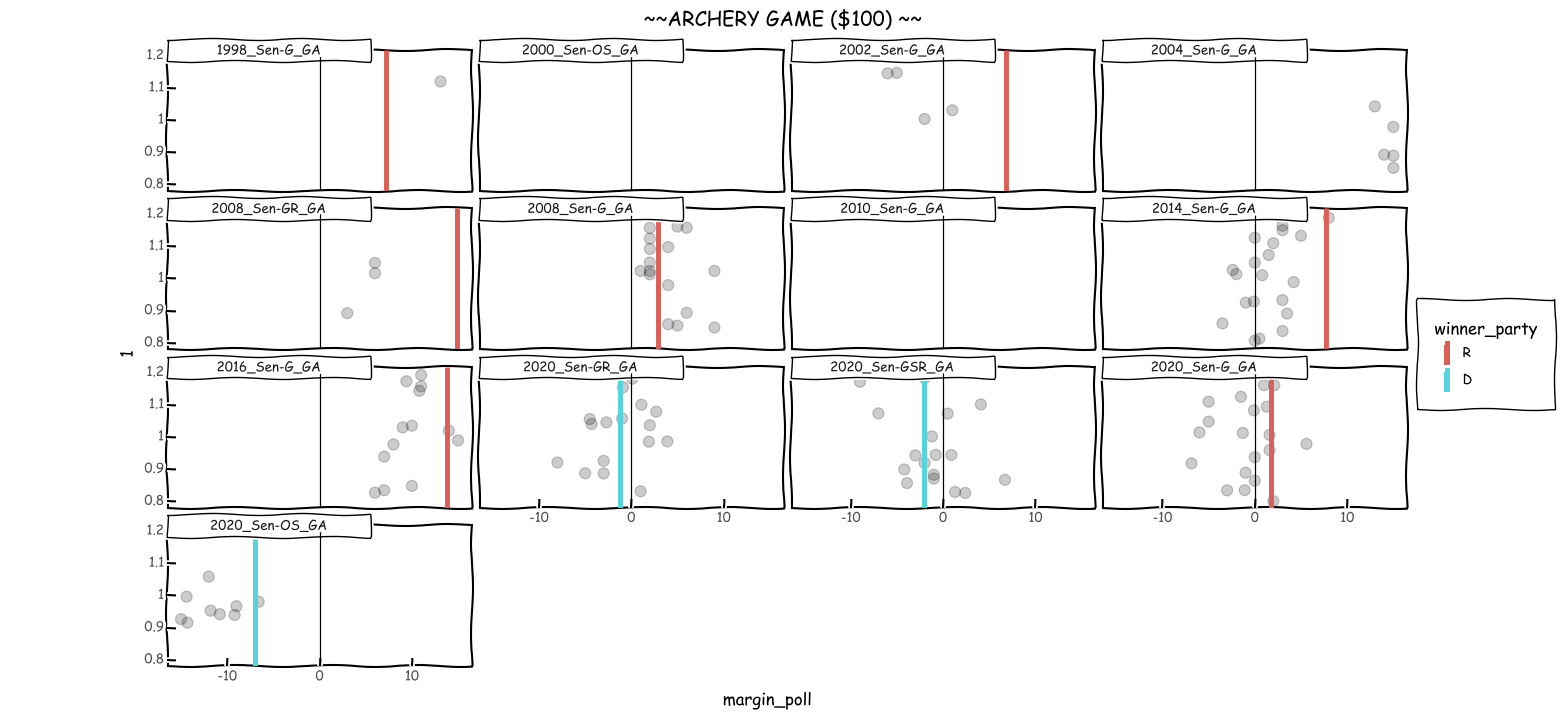

<ggplot: (325685059)>

In [33]:
display(
    ggplot(polls.query('type_simple == "Sen-G" and location == "GA"'), aes(x='margin_poll', y='1'))
     + geom_jitter(aes(width='mose'), size=4, alpha=.2, width=0, height=.2)
#      + geom_point(data=polls_to_analyze.pivot_table(index='year', aggfunc='mean', values='margin_poll').reset_index(), shape='x', size=8) 
     + geom_vline(aes(xintercept='margin_actual', color="winner_party"), size=2)
     + geom_vline(aes(xintercept=0))
     + theme_xkcd()
     + theme(figure_size=(16, 8)) 
     + xlim(-15,15)
     + labs(title='                                                                                                          ~~ARCHERY GAME ($100) ~~                                                                                                    ')
     + facet_wrap('race')
)


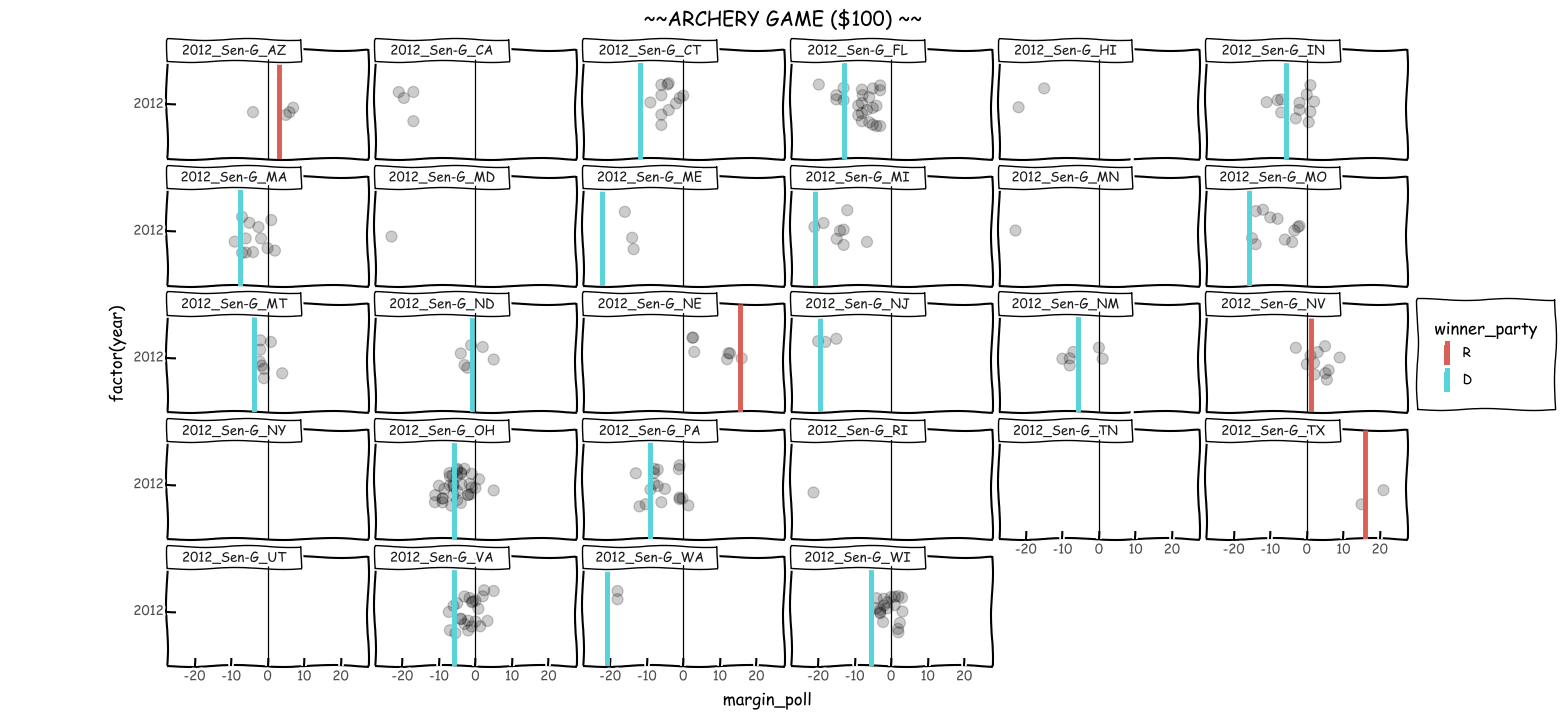

<ggplot: (326142946)>

In [34]:
display(
    ggplot(polls.query('type_simple == "Sen-G" and year == 2012'), aes(x='margin_poll', y='factor(year)'))
     + geom_jitter(aes(width='mose'), size=4, alpha=.2, width=0, height=.2)
#      + geom_point(data=polls_to_analyze.pivot_table(index='year', aggfunc='mean', values='margin_poll').reset_index(), shape='x', size=8) 
     + geom_vline(aes(xintercept='margin_actual', color="winner_party"), size=2)
     + geom_vline(aes(xintercept=0))
     + theme_xkcd()
     + theme(figure_size=(16, 8)) 
     + xlim(-25,25)
     + labs(title='                                                                                                          ~~ARCHERY GAME ($100) ~~                                                                                                    ')
     + facet_wrap('race')
)


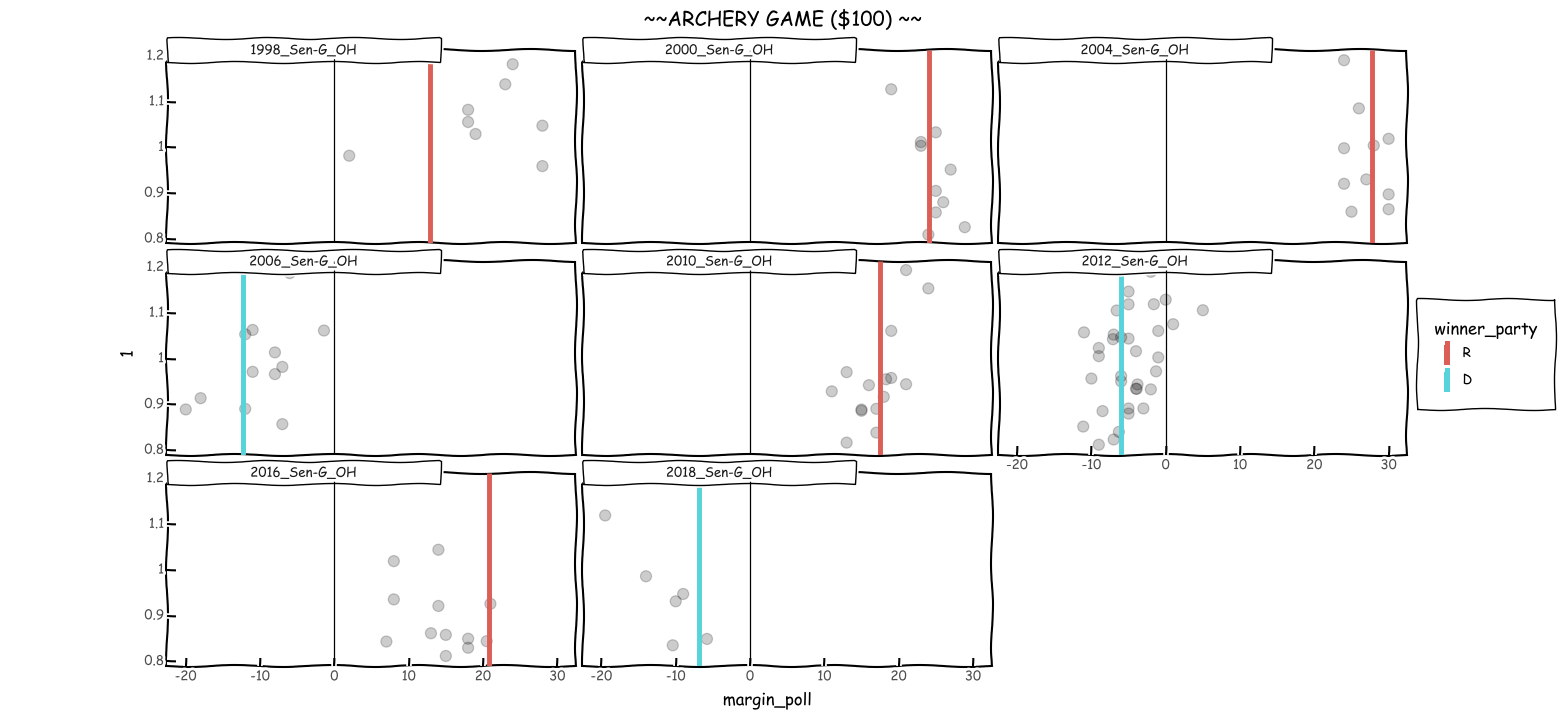

<ggplot: (326154292)>

In [52]:
display(
    ggplot(polls.query('type_simple == "Sen-G" and location == "OH"'), aes(x='margin_poll', y='1'))
     + geom_jitter(aes(width='mose'), size=4, alpha=.2, width=0, height=.2)
#      + geom_point(data=polls_to_analyze.pivot_table(index='year', aggfunc='mean', values='margin_poll').reset_index(), shape='x', size=8) 
     + geom_vline(aes(xintercept='margin_actual', color="winner_party"), size=2)
     + geom_vline(aes(xintercept=0))
     + theme_xkcd()
     + theme(figure_size=(16, 8)) 
     + xlim(-20,30)
     + labs(title='                                                                                                          ~~ARCHERY GAME ($100) ~~                                                                                                    ')
     + facet_wrap('race')
)


In [50]:
polls.query('type_simple == "Sen-G" and location == "OH" and year==2016')

poll_id  question_id  race_id  year           race location type_simple  \
7995    47094        73712       67  2016  2016_Sen-G_OH       OH       Sen-G   
8077    47353        74106       67  2016  2016_Sen-G_OH       OH       Sen-G   
8237    47650        74621       67  2016  2016_Sen-G_OH       OH       Sen-G   
8277    47757        74745       67  2016  2016_Sen-G_OH       OH       Sen-G   
8329    47918        75135       67  2016  2016_Sen-G_OH       OH       Sen-G   
8462    48100        75466       67  2016  2016_Sen-G_OH       OH       Sen-G   
8529    48111        75326       67  2016  2016_Sen-G_OH       OH       Sen-G   
8574    48479        75972       67  2016  2016_Sen-G_OH       OH       Sen-G   
8668    48481        75979       67  2016  2016_Sen-G_OH       OH       Sen-G   
8724    48680        76252       67  2016  2016_Sen-G_OH       OH       Sen-G   
8725    48895        76540       67  2016  2016_Sen-G_OH       OH       Sen-G   
8843    48516        76048       67  2016  2016_Sen-G_OH       OH       Sen-G   

     type_detail                                  pollster  \
7995       Sen-G                        Suffolk University   
8077       Sen-G  Rasmussen Reports/Pulse Opinion Research   
8237       Sen-G  Rasmussen Reports/Pulse Opinion Research   
8277       Sen-G                           Emerson College   
8329       Sen-G                              SurveyMonkey   
8462       Sen-G                     Quinnipiac University   
8529       Sen-G  Rasmussen Reports/Pulse Opinion Research   
8574       Sen-G                         Columbus Dispatch   
8668       Sen-G                                    YouGov   
8724       Sen-G  Rasmussen Reports/Pulse Opinion Research   
8725       Sen-G                              SurveyMonkey   
8843       Sen-G                           Emerson College   

      pollster_rating_id methodology partisan   polldate  samplesize  \
7995                 323  Live Phone      NaN 2016-10-18       500.0   
8077                 277  IVR/Online      NaN 2016-10-21       875.0   
8237                 277  IVR/Online      NaN 2016-10-26       525.0   
8277                  88         IVR      NaN 2016-10-27       800.0   
8329                 324      Online      NaN 2016-10-28      1823.0   
8462                 267  Live Phone      NaN 2016-10-30       589.0   
8529                 277  IVR/Online      NaN 2016-10-31       525.0   
8574                  57        Mail      NaN 2016-11-01      1151.0   
8668                 391      Online      NaN 2016-11-03      1189.0   
8724                 277  IVR/Online      NaN 2016-11-04       525.0   
8725                 324      Online      NaN 2016-11-04      2860.0   
8843                  88         IVR      NaN 2016-11-05       900.0   

          cand1_name  cand1_id cand1_party  cand1_pct   cand2_name  cand2_id  \
7995  Ted Strickland      9021         DEM       30.8  Rob Portman      9020   
8077  Ted Strickland      9021         DEM       40.0  Rob Portman      9020   
8237  Ted Strickland      9021         DEM       42.0  Rob Portman      9020   
8277  Ted Strickland      9021         DEM       35.0  Rob Portman      9020   
8329  Ted Strickland      9021         DEM       40.0  Rob Portman      9020   
8462  Ted Strickland      9021         DEM       38.0  Rob Portman      9020   
8529  Ted Strickland      9021         DEM       41.0  Rob Portman      9020   
8574  Ted Strickland      9021         DEM       37.0  Rob Portman      9020   
8668  Ted Strickland      9021         DEM       39.0  Rob Portman      9020   
8724  Ted Strickland      9021         DEM       38.0  Rob Portman      9020   
8725  Ted Strickland      9021         DEM       39.0  Rob Portman      9020   
8843  Ted Strickland      9021         DEM       28.3  Rob Portman      9020   

     cand2_party  cand2_pct  cand3_pct  margin_poll electiondate  \
7995         REP       45.8        3.4         15.0   2016-11-08   
8077         REP       48.0    

In [49]:
polls

poll_id  question_id  race_id  year             race location  \
0        26013        87909     1455  1998    1998_Gov-G_NY       NY   
1        26255        87926     1456  1998    1998_Gov-G_OH       OH   
2        26026        31266     1736  1998    1998_Sen-G_NV       NV   
3        26013        31253     1738  1998    1998_Sen-G_NY       NY   
4        63632       117103     1738  1998    1998_Sen-G_NY       NY   
...        ...          ...      ...   ...              ...      ...   
10771    74006       138846     7781  2020  2020_Sen-GSR_GA       GA   
10772    73993       138823     8737  2020   2020_Sen-GR_GA       GA   
10773    73991       138819     8737  2020   2020_Sen-GR_GA       GA   
10774    73992       138821     8737  2020   2020_Sen-GR_GA       GA   
10775    74006       138845     8737  2020   2020_Sen-GR_GA       GA   

      type_simple type_detail                              pollster  \
0           Gov-G       Gov-G              Blum & Weprin Associates   
1           Gov-G       Gov-G  University of Cincinnati (Ohio Poll)   
2           Sen-G       Sen-G                          FM3 Research   
3           Sen-G       Sen-G              Blum & Weprin Associates   
4           Sen-G       Sen-G        Garin-Hart-Yang Research Group   
...           ...         ...                                   ...   
10771       Sen-G     Sen-GSR                       Trafalgar Group   
10772       Sen-G      Sen-GR                            AtlasIntel   
10773       Sen-G      Sen-GR                National Research Inc.   
10774       Sen-G      Sen-GR        Opinion Savvy/InsiderAdvantage   
10775       Sen-G      Sen-GR                       Trafalgar Group   

       pollster_rating_id        methodology partisan   polldate  samplesize  \
0                      32         Live Phone      NaN 1998-10-13       364.0   
1                     346         Live Phone      NaN 1998-10-13       540.0   
2                      91         Live Phone        D 1998-10-13       488.0   
3                      32         Live Phone      NaN 1998-10-13       364.0   
4                     113         Live Phone        D 1998-10-13       902.0   
...                   ...                ...      ...        ...         ...   
10771                 338    IVR/Online/Text        R 2021-01-03      1056.0   
10772                 546  Live Phone/Online      NaN 2021-01-03       857.0   
10773                 225         Live Phone        R 2021-01-03       500.0   
10774                 243     IVR/Live Phone      NaN 2021-01-03       500.0   
10775                 338    IVR/Online/Text        R 2021-01-03      1056.0   

               cand1_name  cand1_id cand1_party  cand1_pct  \
0           Peter Vallone     13080         DEM       26.0   
1              Lee Fisher     13085         DEM       37.0   
2              Harry Reid      3964         DEM       49.0   
3      Charles E. Schumer      3966         DEM       44.0   
4      Charles E. Schumer      3966         DEM       46.0   
...                   ...       ...         ...        ...   
10771     Raphael Warnock     14489         DEM       48.4   
10772          Jon Ossoff     14567         DEM       51.3   
10773          Jon Ossoff     14567         DEM       46.0   
10774          Jon Ossoff     14567         DEM       48.6   
10775          Jon Ossoff     14567         DEM       49.4   

               cand2_name  cand2_id cand2_party  cand2_pct  cand3_pct  \
0           George Pataki     13083         REP       57.0        9.0   
1                Bob Taft     13086         REP       52.0        NaN   
2             John Ensign      3965         REP       44.0        NaN   
3      Alfonse M. D'Amato      3967         REP       52.0        NaN   
4      Alfonse M. D'Amato      3967         REP       42.0        NaN   
...                   ...       ...         ...        ...        ...   
10771      Kelly Loeffler     13671         REP       49.7        NaN   

In [118]:
ratings = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/pollster-ratings/pollster-ratings.csv')
polls = polls.merge(ratings, left_on='pollster_rating_id', right_on='Pollster Rating ID')
polls['newname'] = polls['pollster'] + ' (' + polls['538 Grade']+ ') '

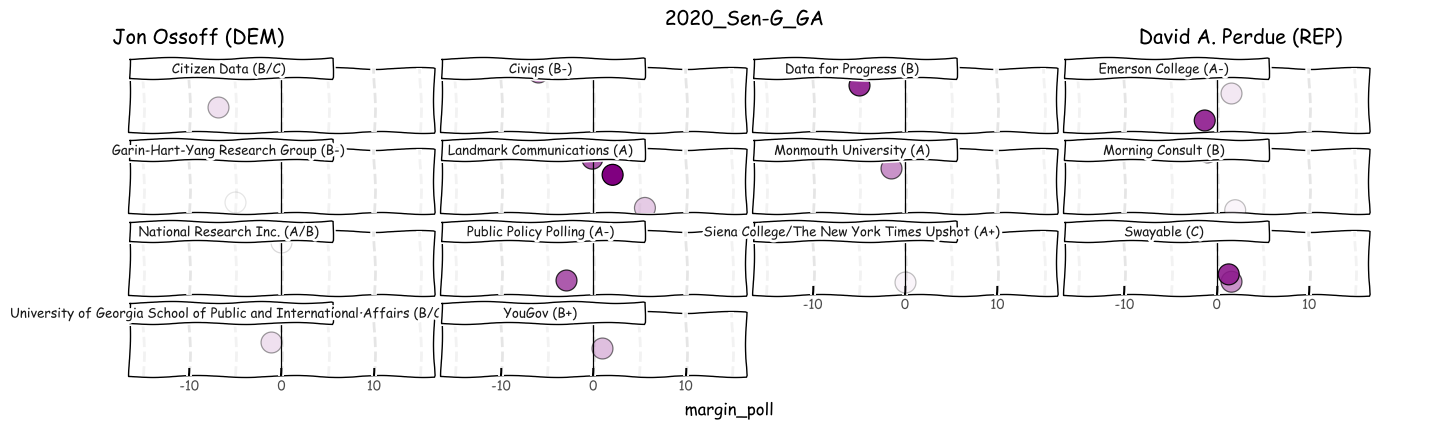

<ggplot: (326945669)>

In [124]:
a_race = '2020_Sen-G_GA'
polls['days_until_election'] = polls['days_until_election'].astype('float')
polls_for_this_race = polls.query('race == @a_race')
cand_1 = f"{polls_for_this_race.iloc[0]['cand1_name']} ({polls_for_this_race.iloc[0]['cand1_party']})"
cand_2 = f"{polls_for_this_race.iloc[0]['cand2_name']} ({polls_for_this_race.iloc[0]['cand2_party']})"

import plotnine as p9
display(
    ggplot(polls.query('race == @a_race'), aes(x='margin_poll', y=1))
     + geom_jitter(aes(width='mose', fill='days_until_election', alpha='days_until_election'), size=8,width=0, height=.2, random_state=42)
#          + geom_point(data=polls_to_analyze.pivot_table(index='year', aggfunc='mean', values='margin_poll').reset_index(), shape='x', size=8) 
#      + geom_vline(aes(xintercept='margin_actual', color="winner_party"), size=2)
#          + geom_rect(aes(xmax=2.5,xmin=-2.5, ymax=float('inf'), ymin=float('-inf')), fill='grey', alpha=.005)
     + geom_vline(aes(xintercept=0))
     + p9.scale_fill_gradient(low="white",high="purple", values=[-21,0])
     + xlim(-15,15)
         + labs(title=f'                                                                                                          {a_race}                                                                                                    ' +
                      f'\n{cand_1}                                                                                                                                               {cand_2}' )

     + theme_xkcd()
     + theme(figure_size=(16, 4),
            legend_position='none',
            axis_text_y= element_blank(), axis_line_y= element_blank(),
            axis_title_y=element_blank(), axis_ticks_minor_y=element_blank(), axis_ticks_major_y=element_blank(),
            panel_grid_major_x = element_line(color='grey', size=2, linetype='dashed', alpha=.2),
            panel_grid_minor_x = element_line(color='grey', size=2, linetype='dashed', alpha=.1),
            panel_border=element_rect(color='black', size=1)) + facet_wrap('newname')
)

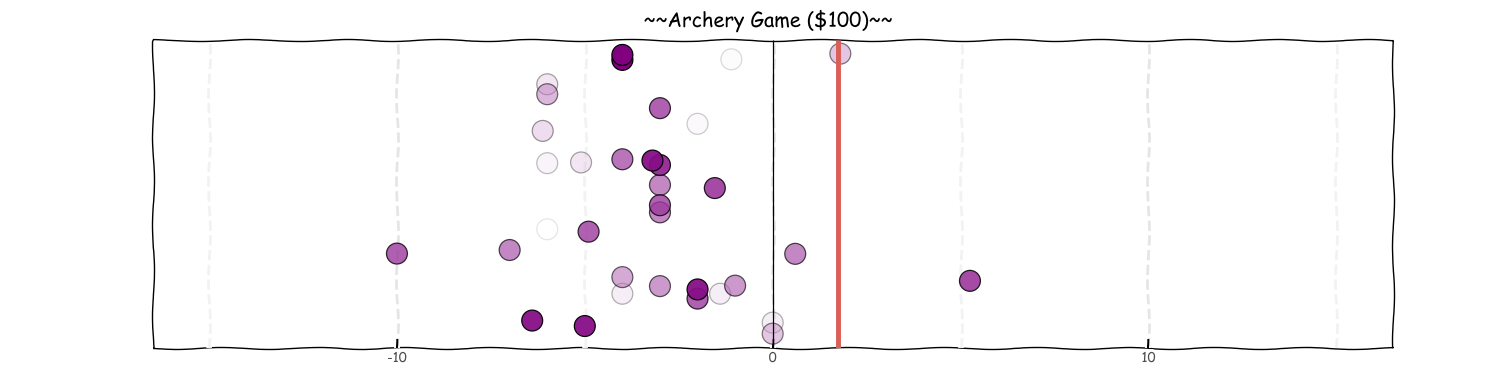

<ggplot: (327373246)>

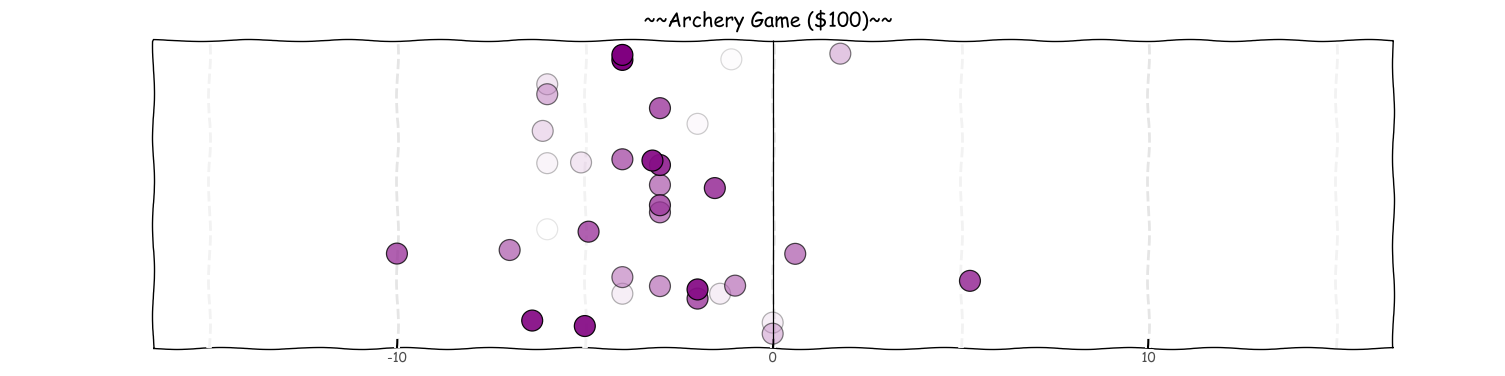

<ggplot: (327367563)>

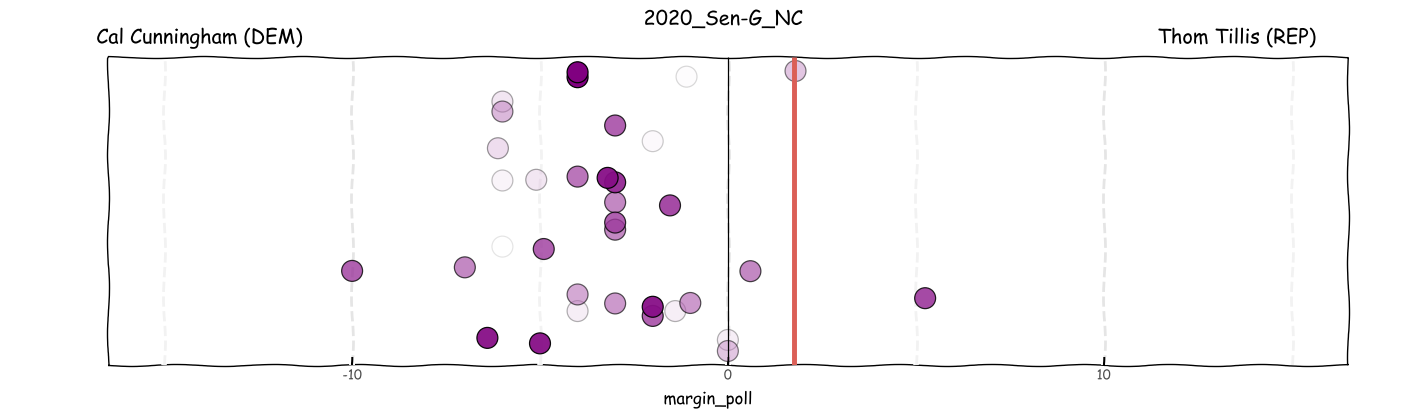

<ggplot: (327373719)>

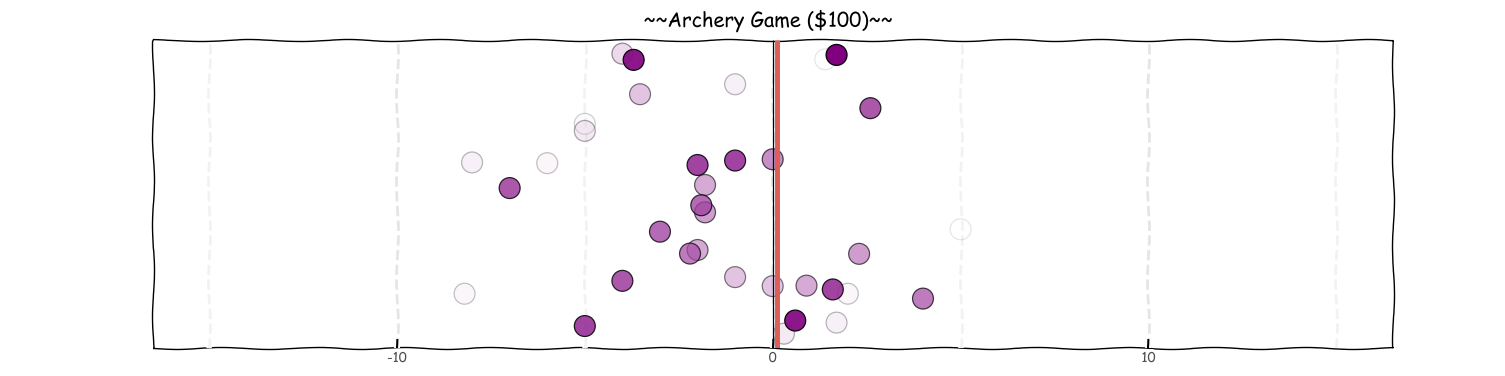

<ggplot: (326324580)>

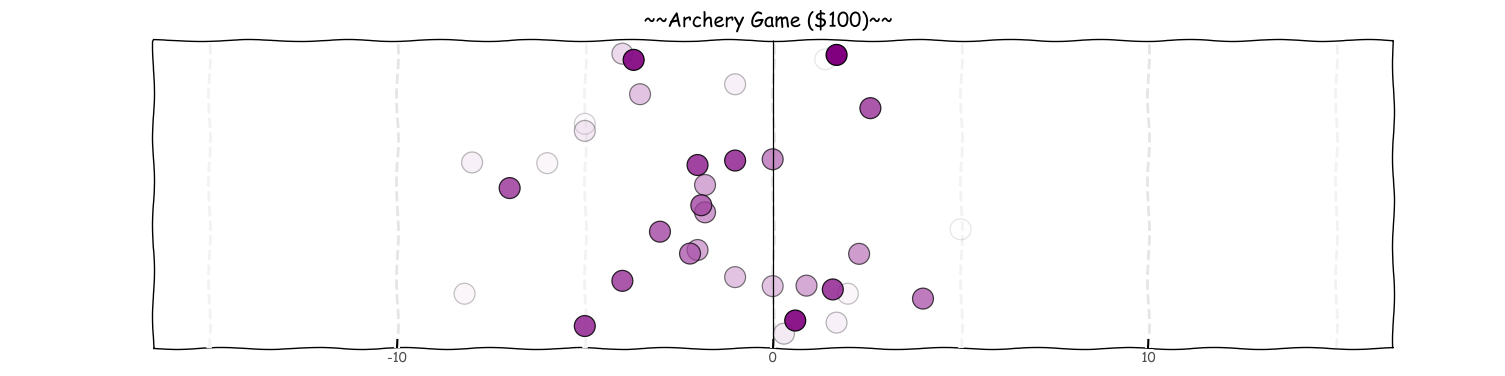

<ggplot: (327049457)>

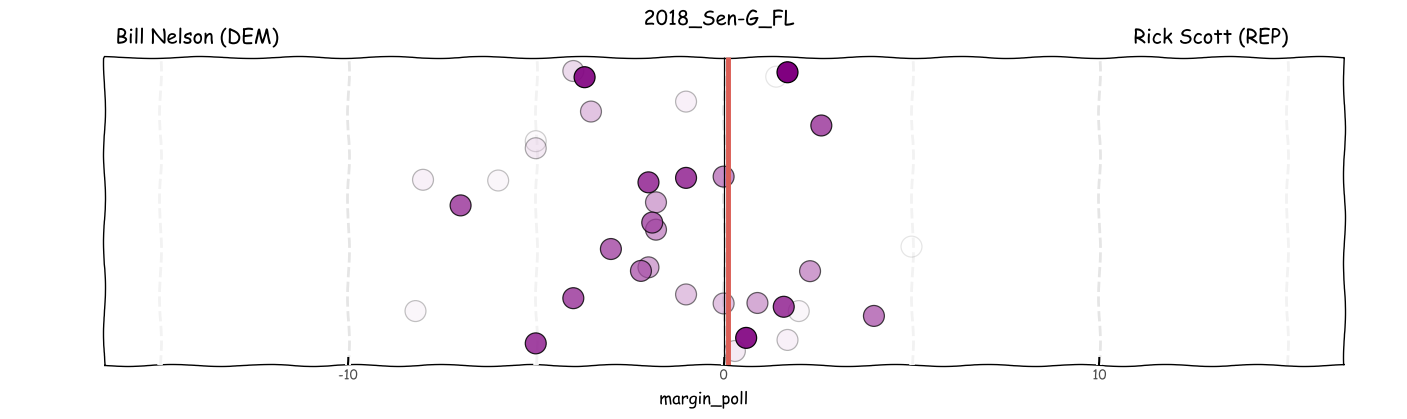

<ggplot: (326503361)>

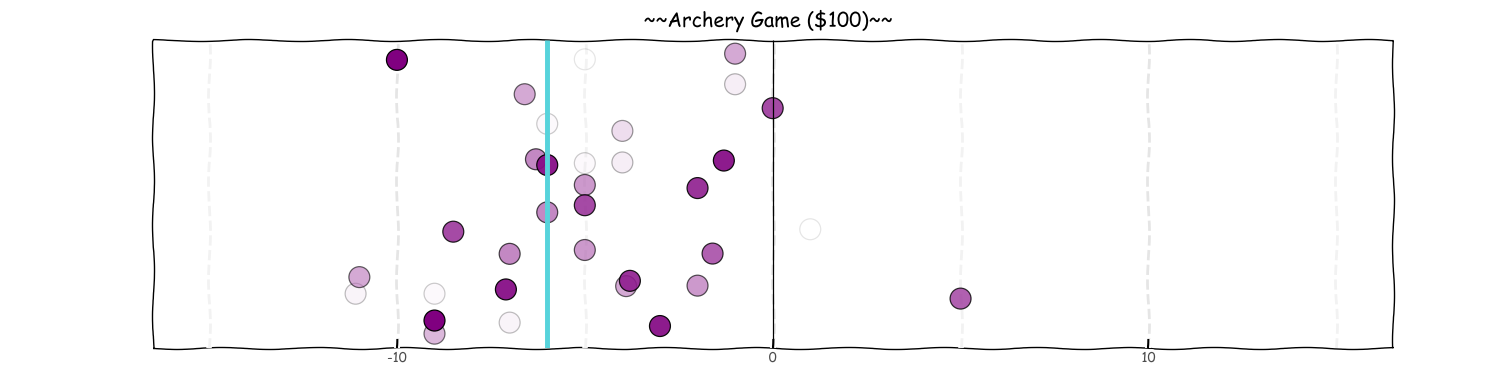

<ggplot: (326257104)>

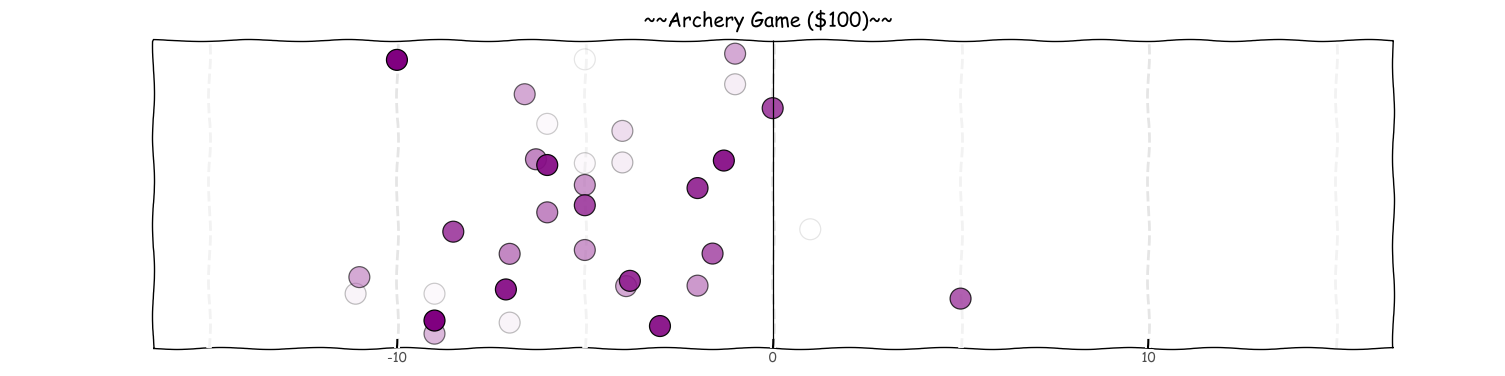

<ggplot: (326587938)>

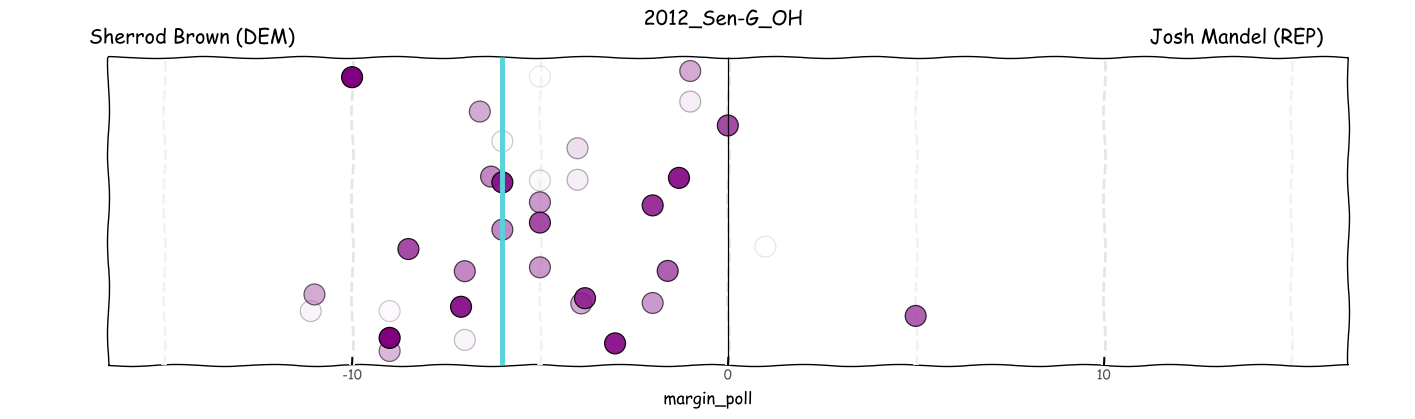

<ggplot: (326478005)>

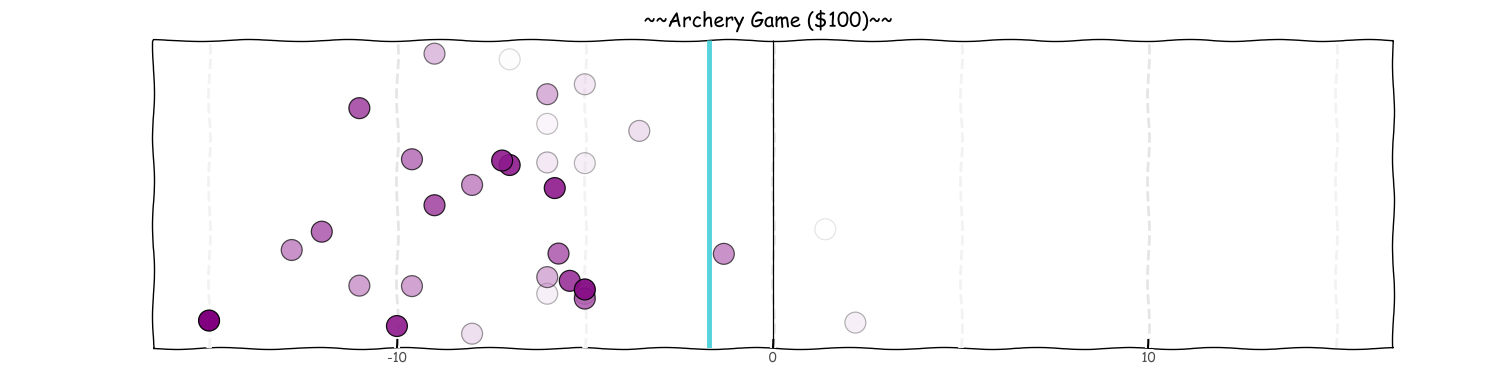

<ggplot: (326733267)>

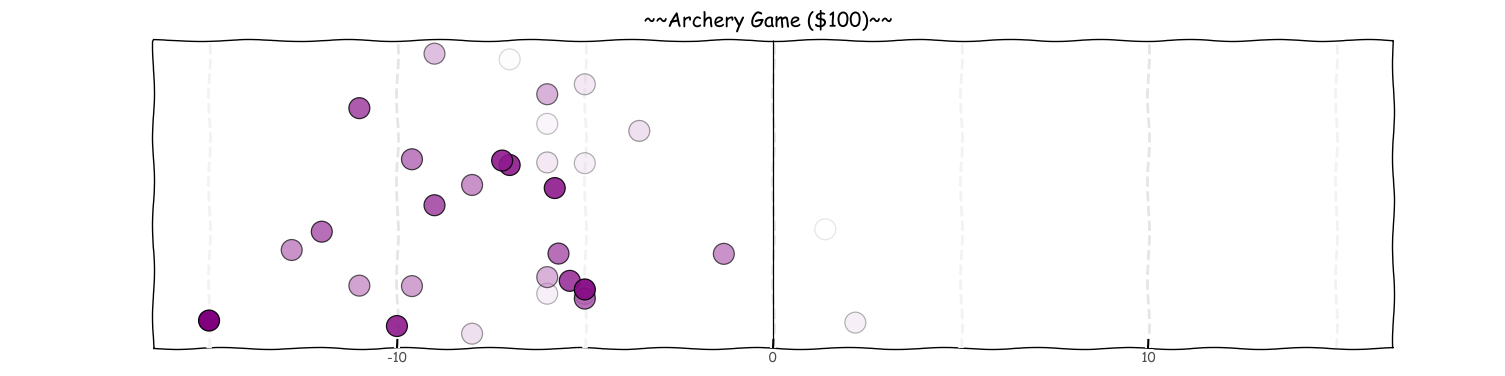

<ggplot: (326477852)>

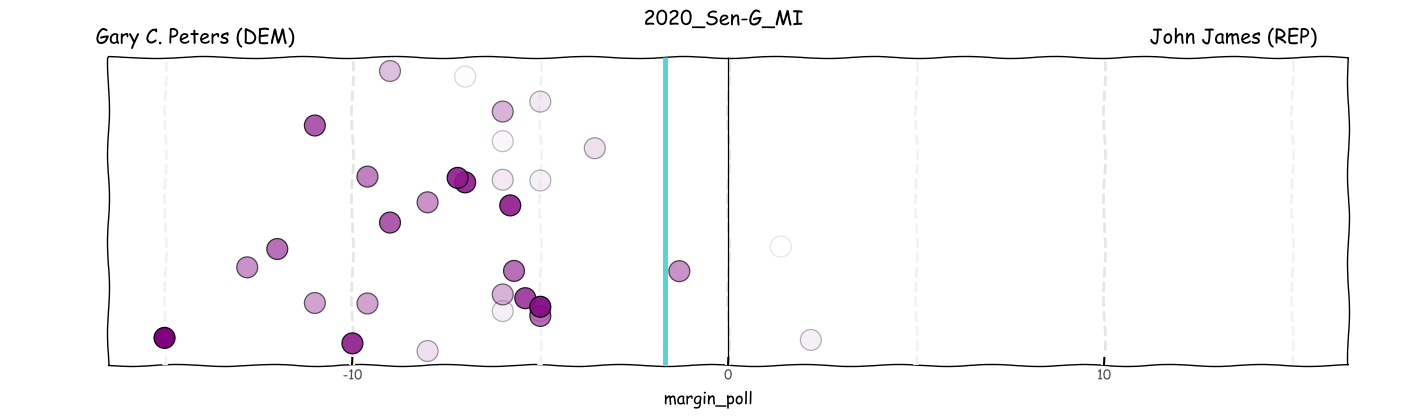

<ggplot: (326187990)>

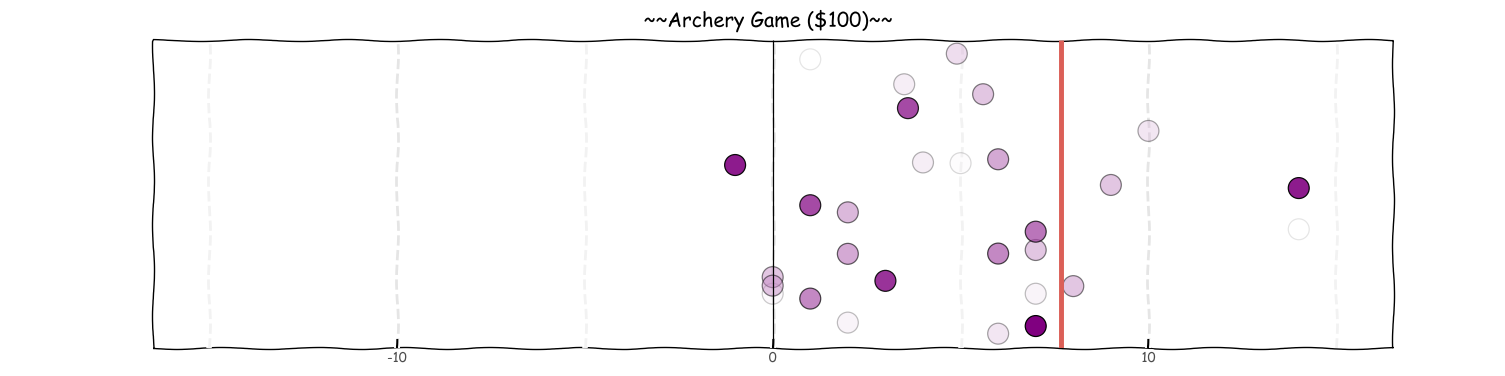

<ggplot: (326218518)>

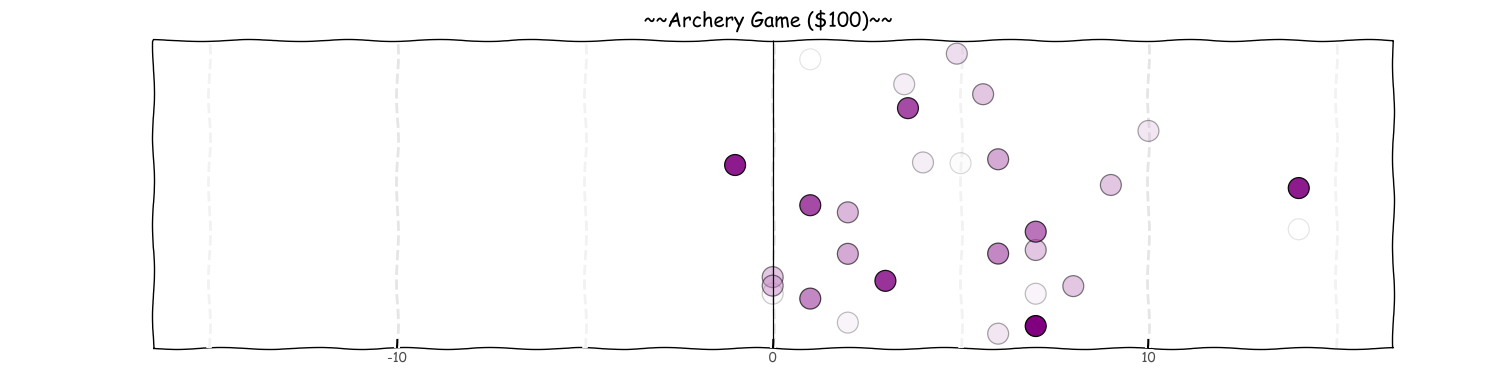

<ggplot: (327287197)>

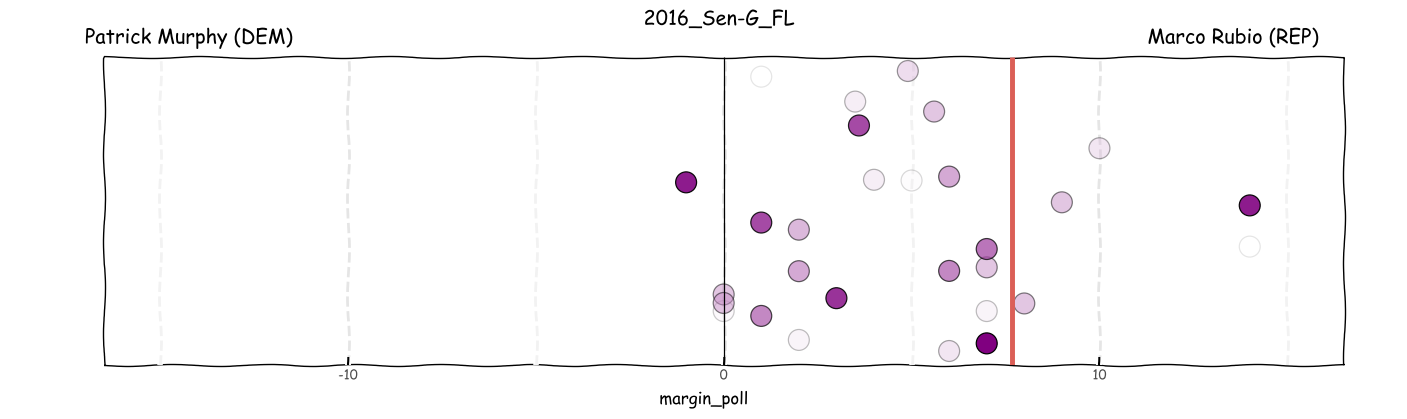

<ggplot: (326214039)>

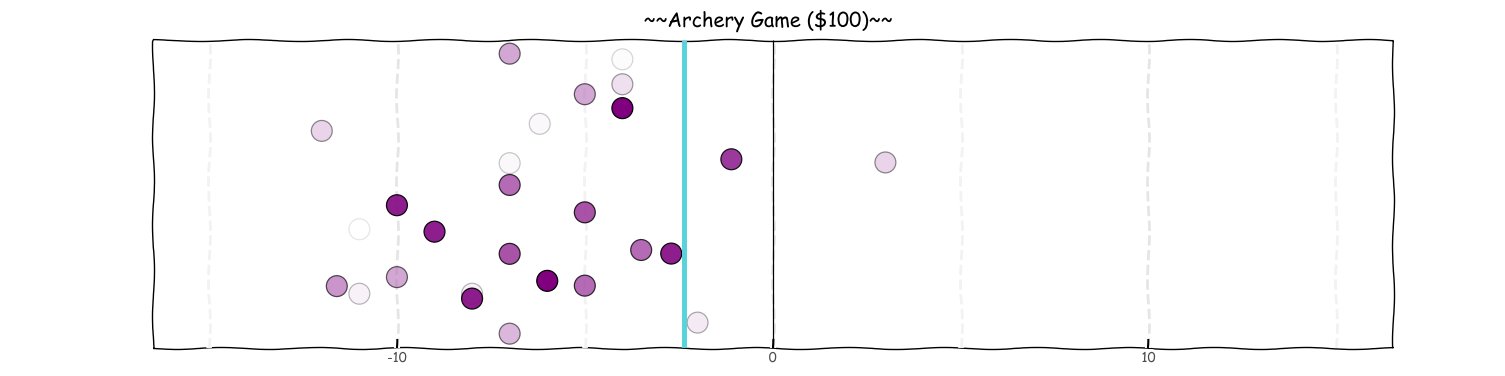

<ggplot: (326303061)>

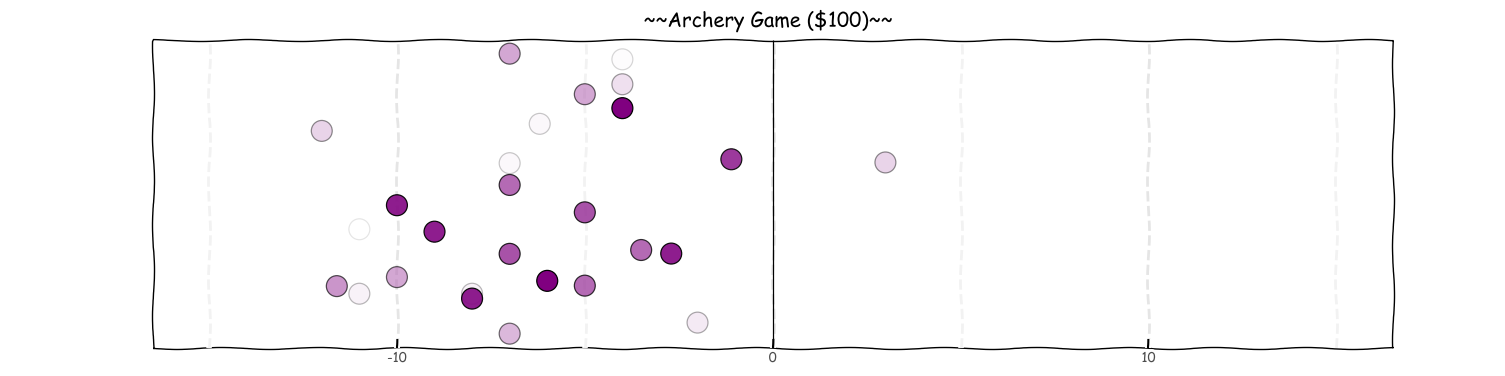

<ggplot: (326908290)>

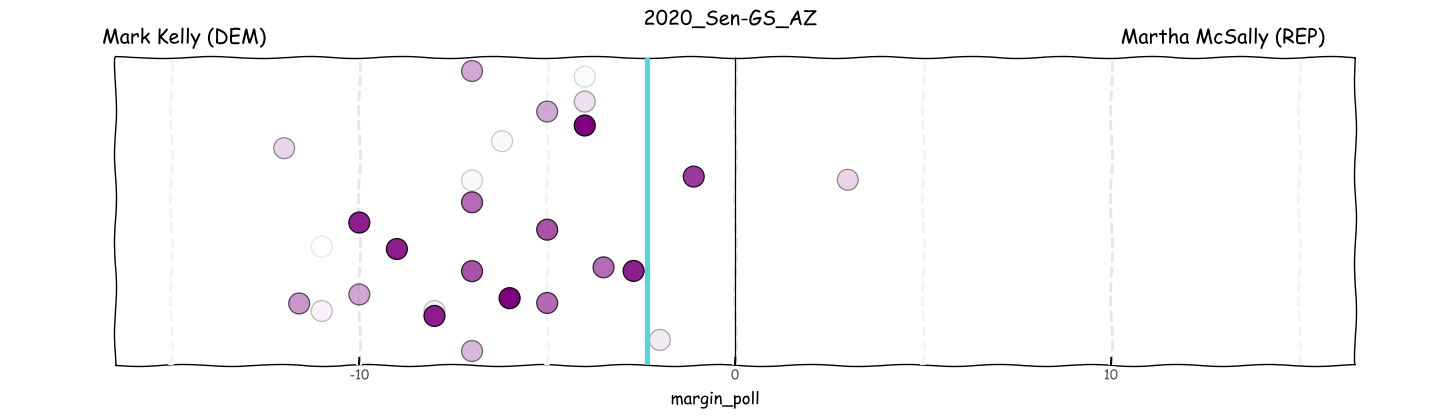

<ggplot: (326288032)>

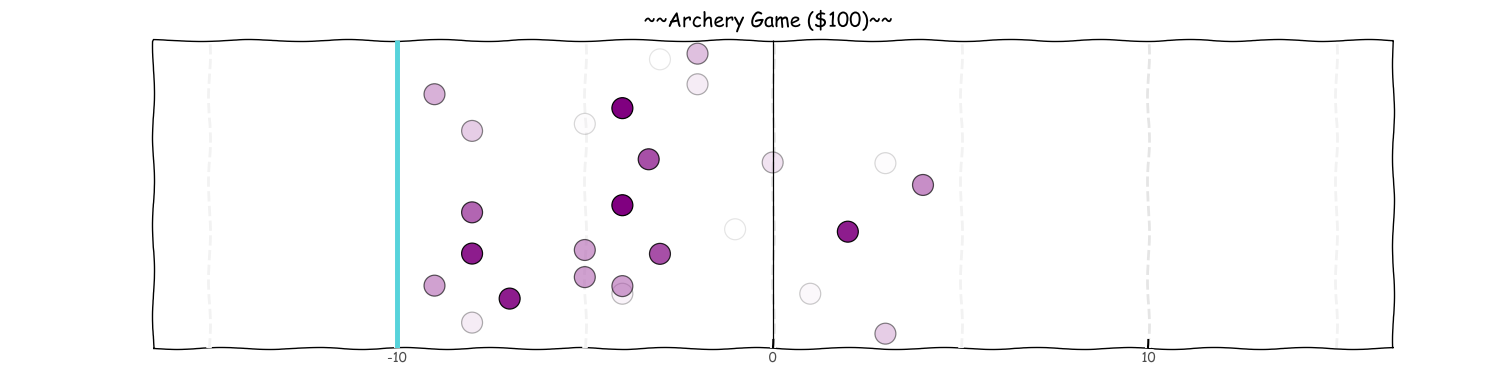

<ggplot: (326366925)>

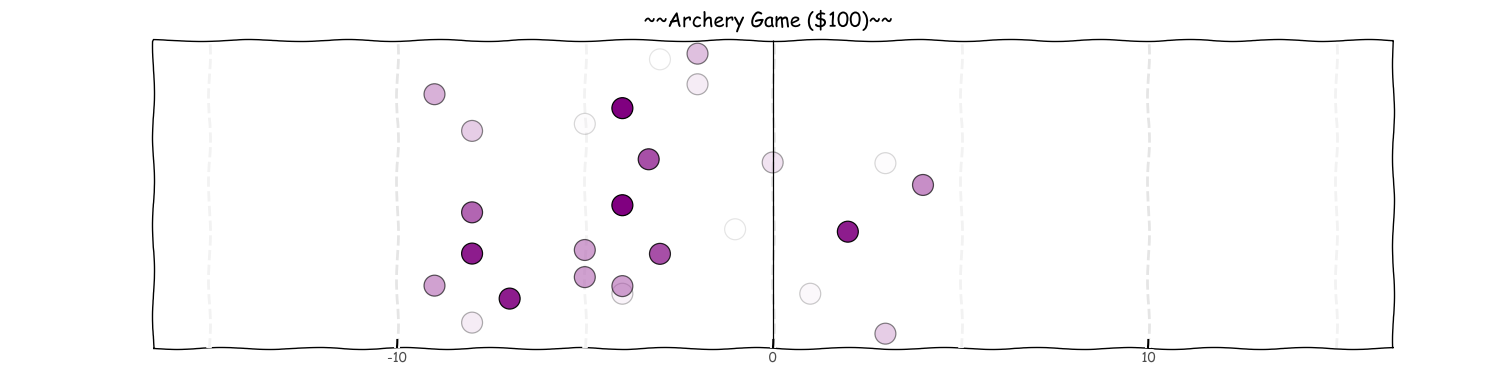

<ggplot: (326436166)>

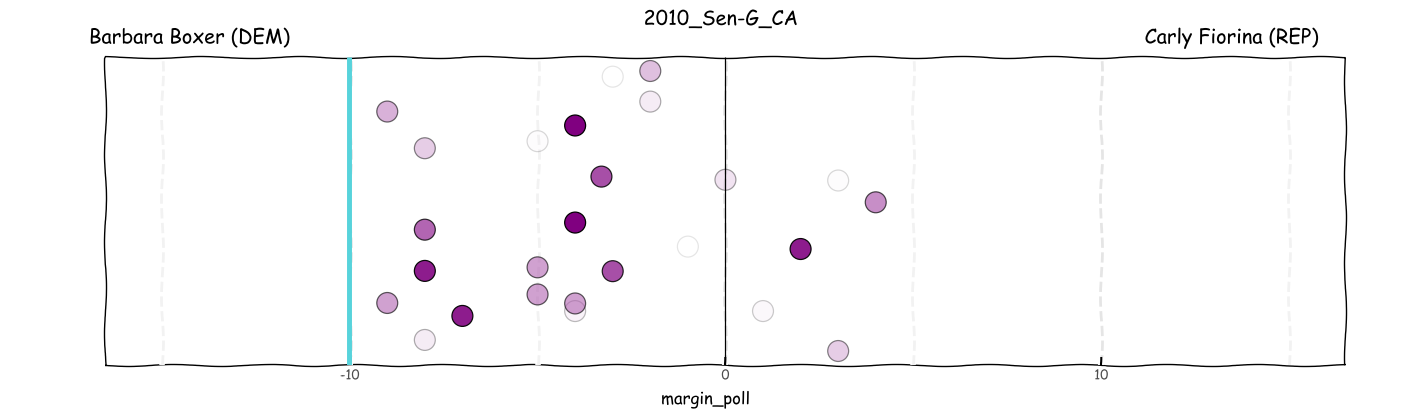

<ggplot: (326366522)>

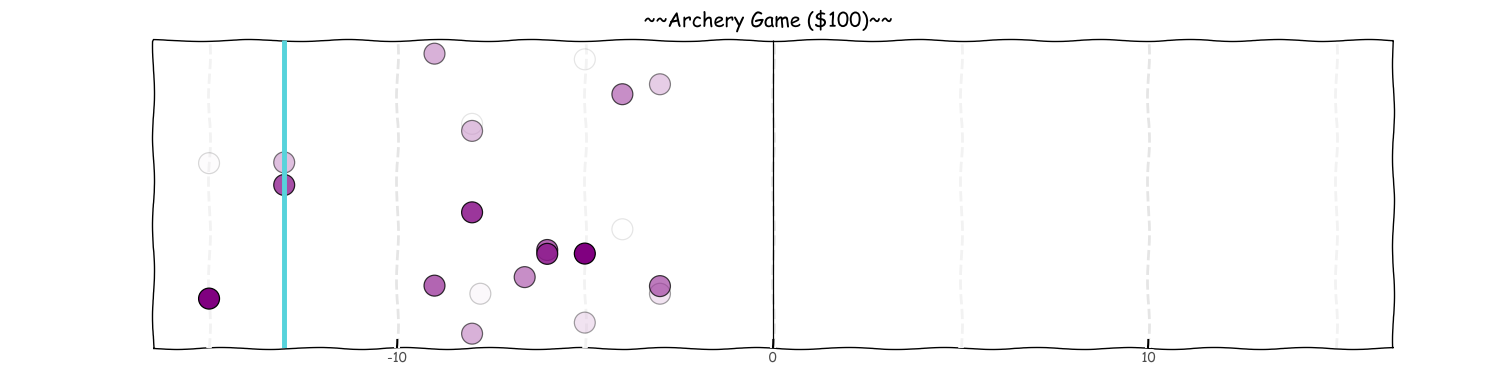

<ggplot: (327308026)>

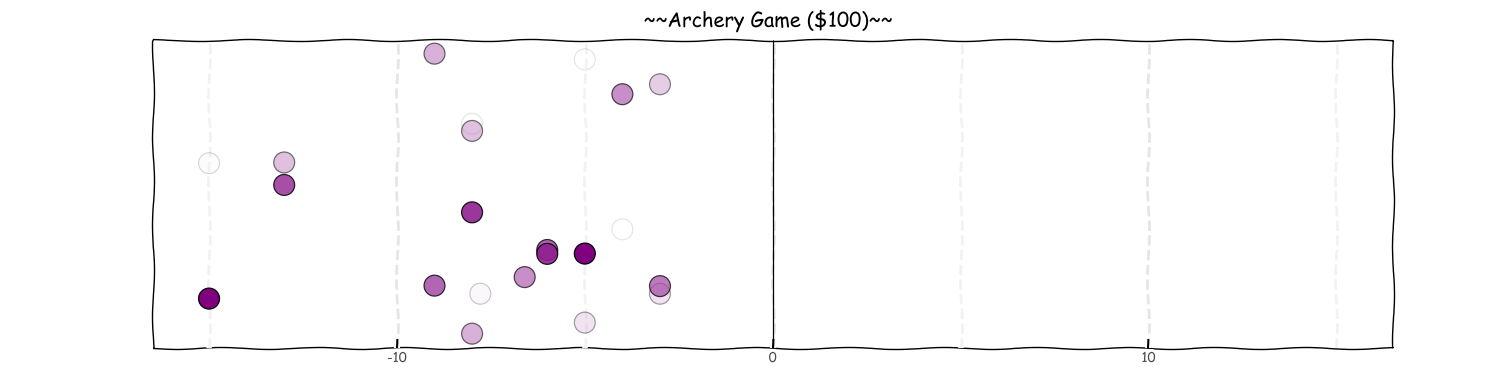

<ggplot: (326751838)>

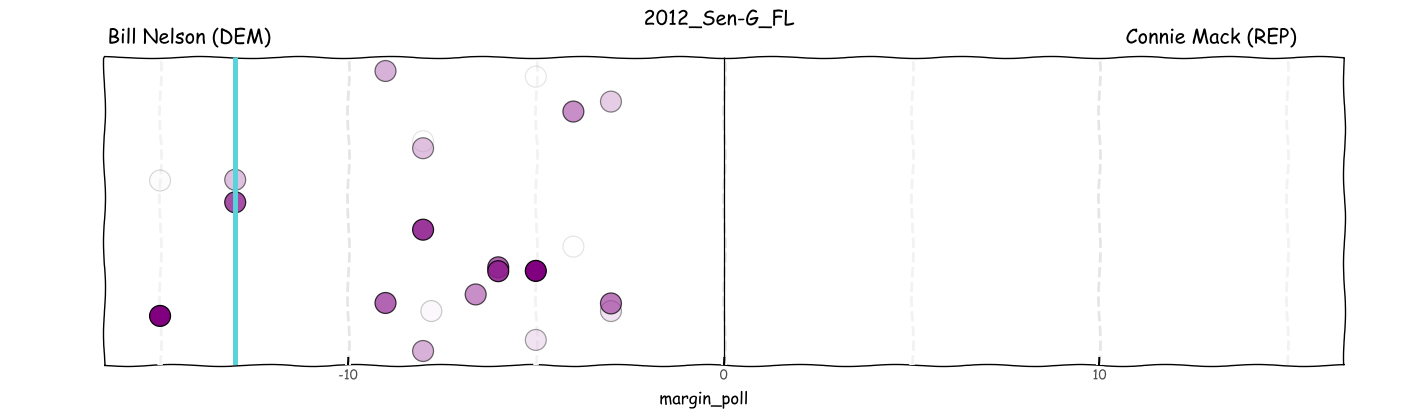

<ggplot: (326663876)>

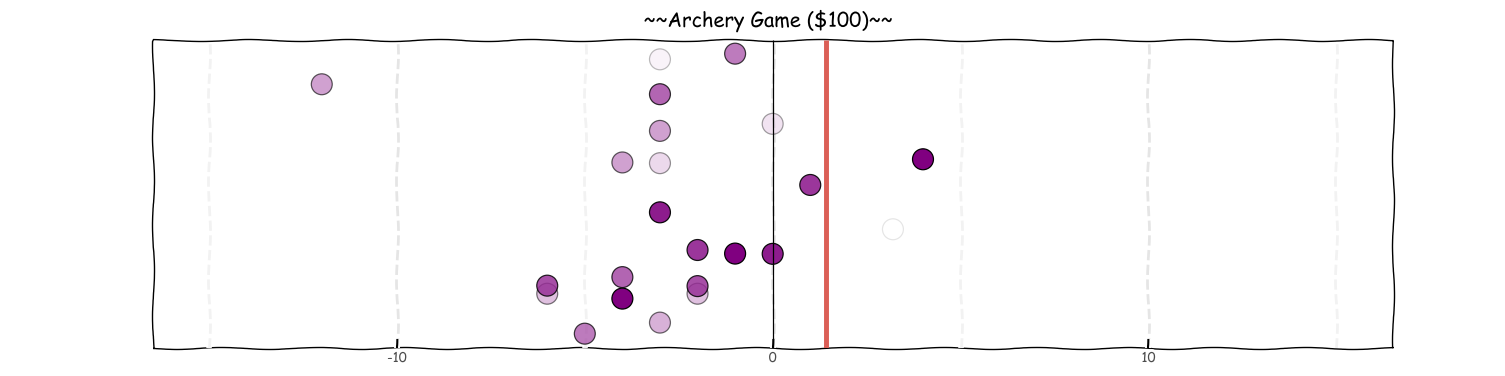

<ggplot: (326960424)>

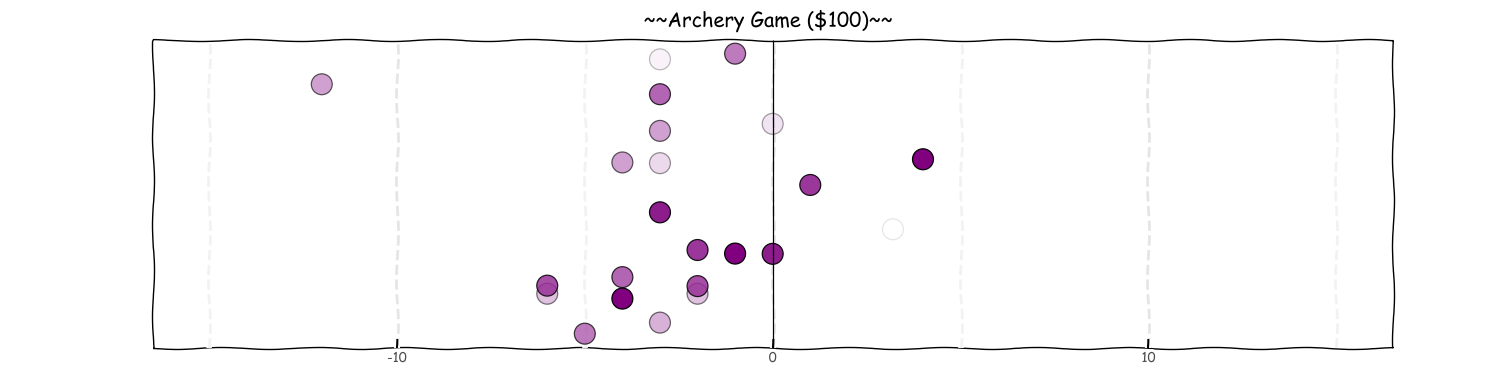

<ggplot: (326154527)>

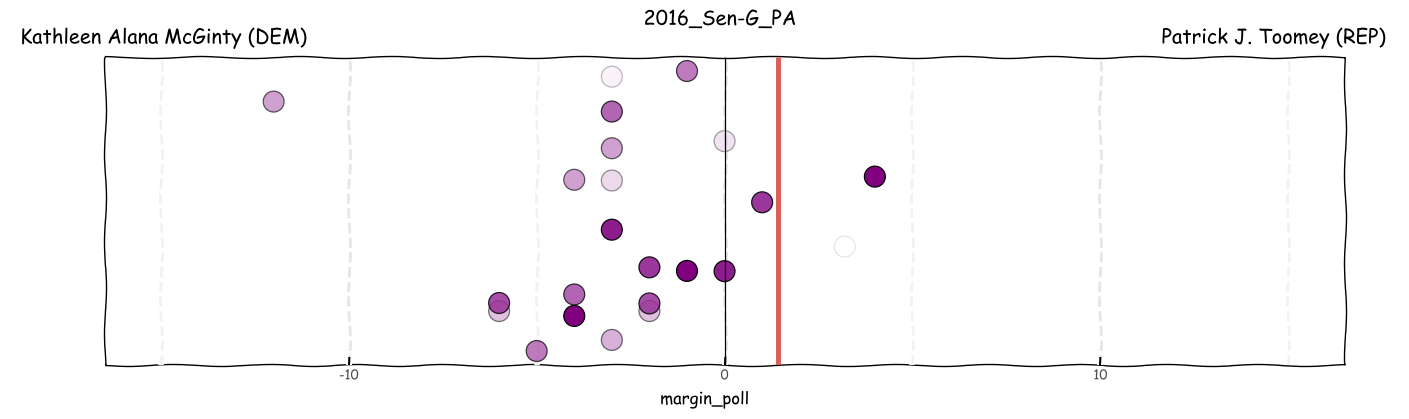

<ggplot: (327271159)>

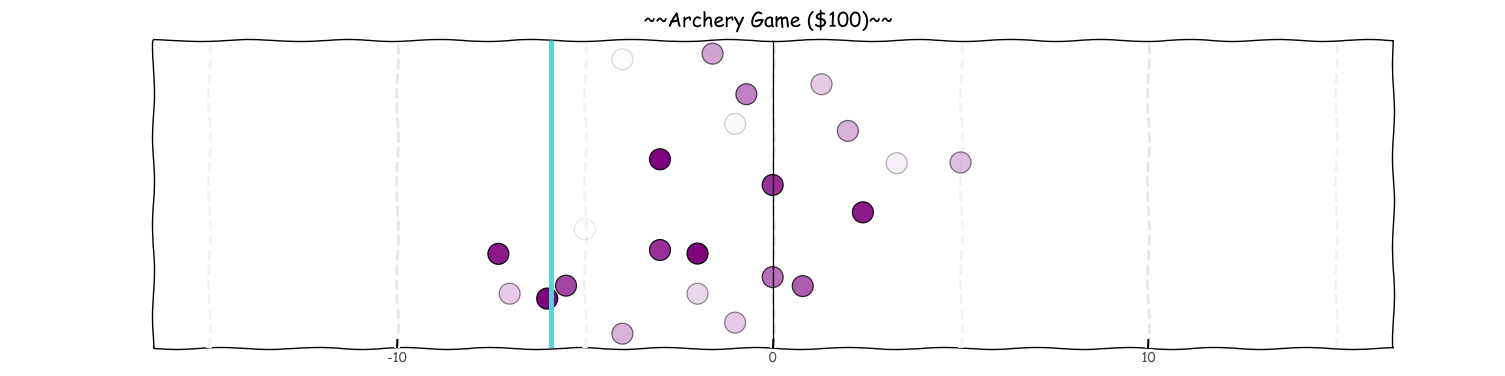

<ggplot: (326300956)>

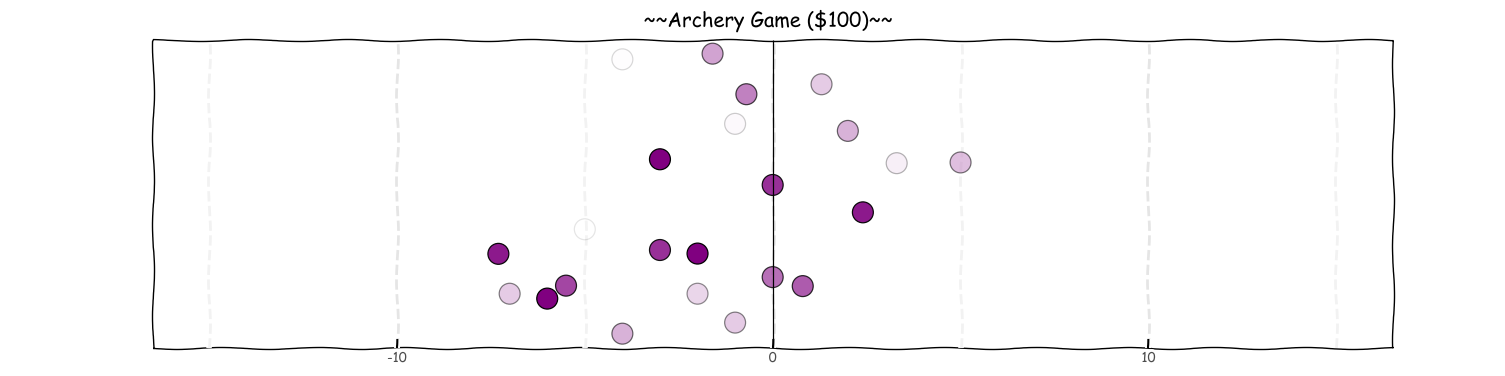

<ggplot: (326211696)>

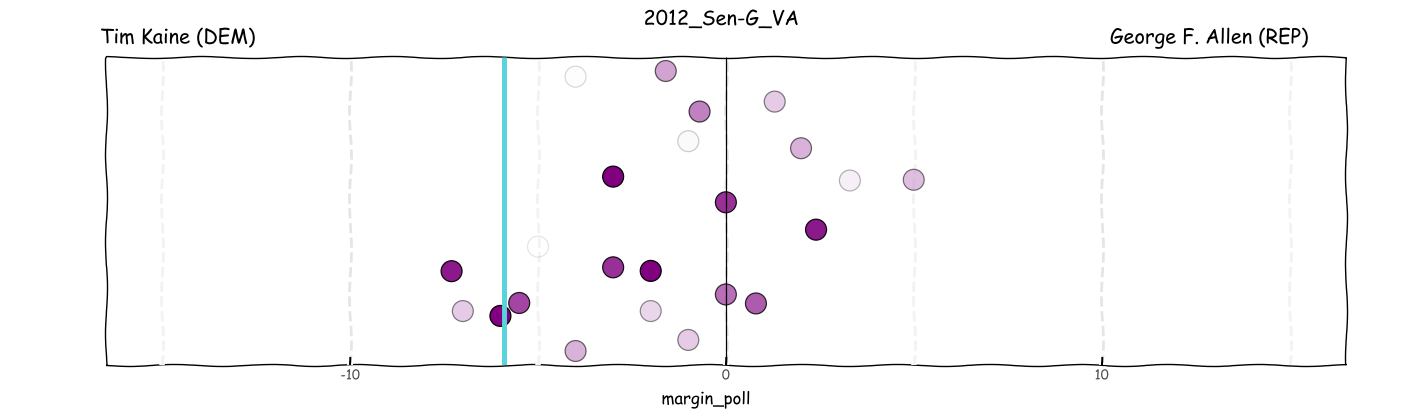

<ggplot: (325854431)>

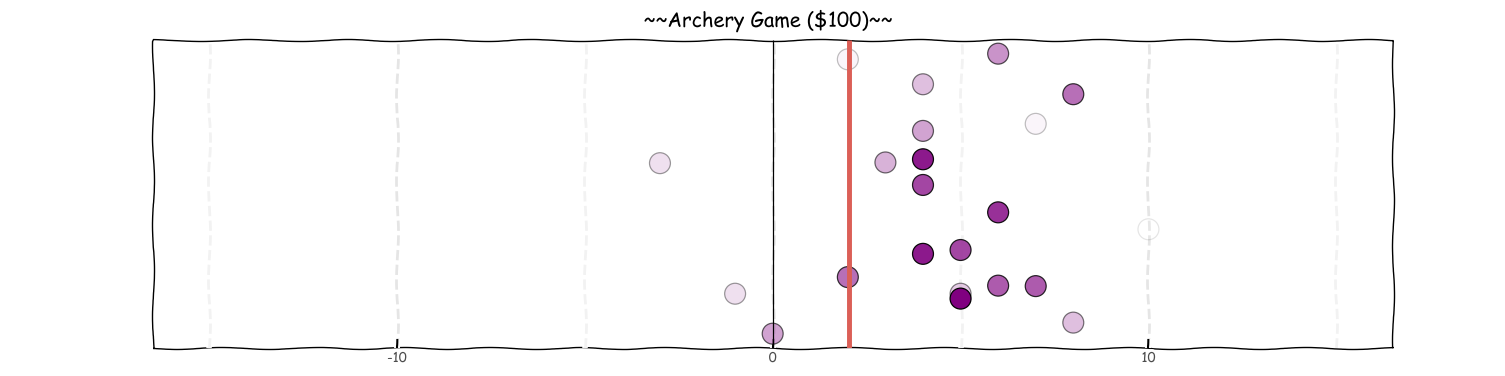

<ggplot: (325663070)>

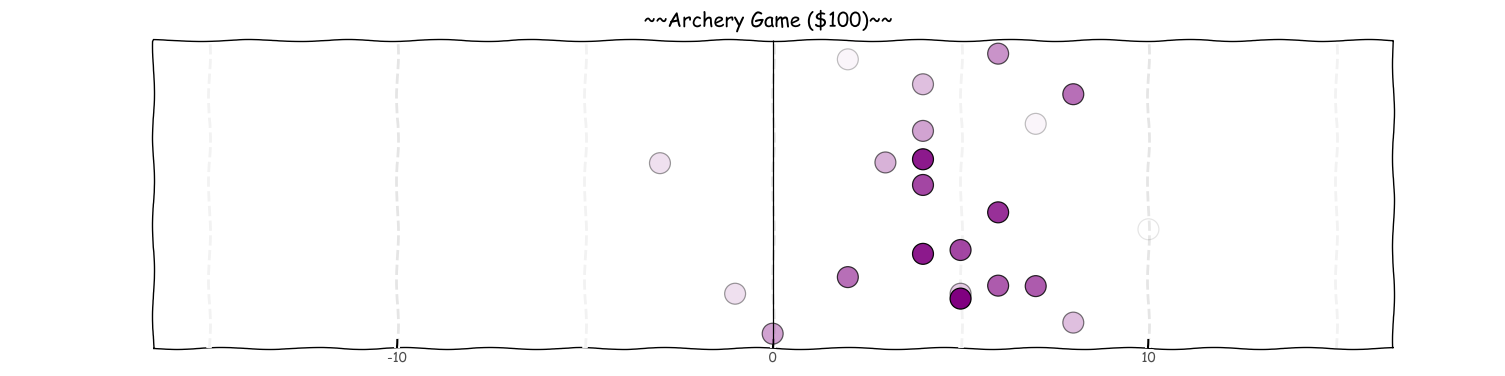

<ggplot: (326184183)>

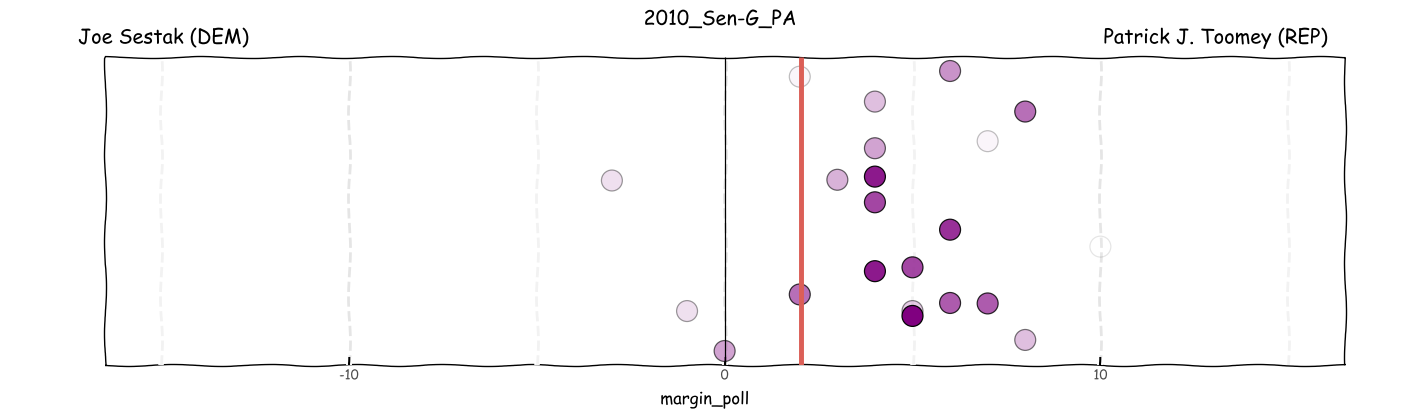

<ggplot: (326965754)>

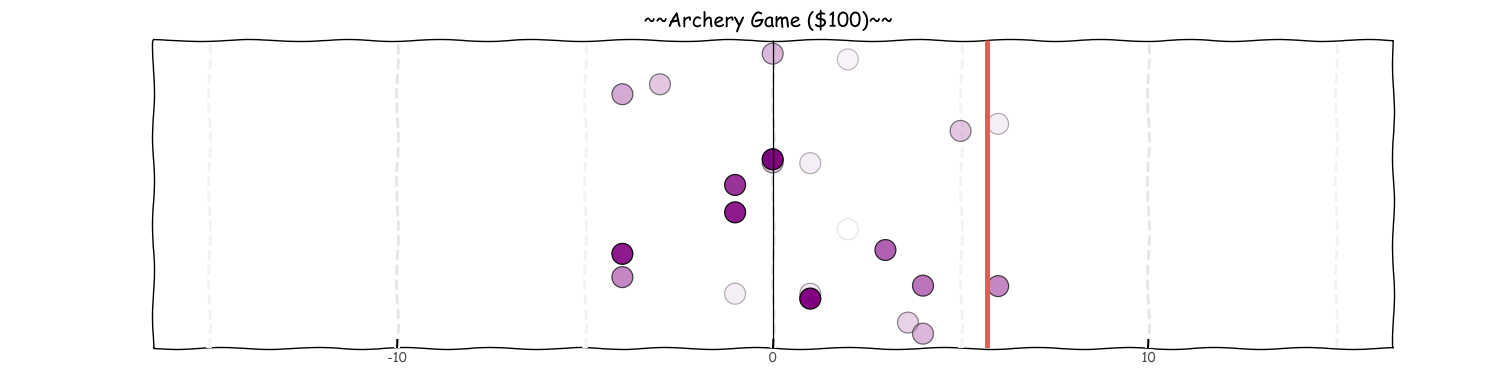

<ggplot: (325861151)>

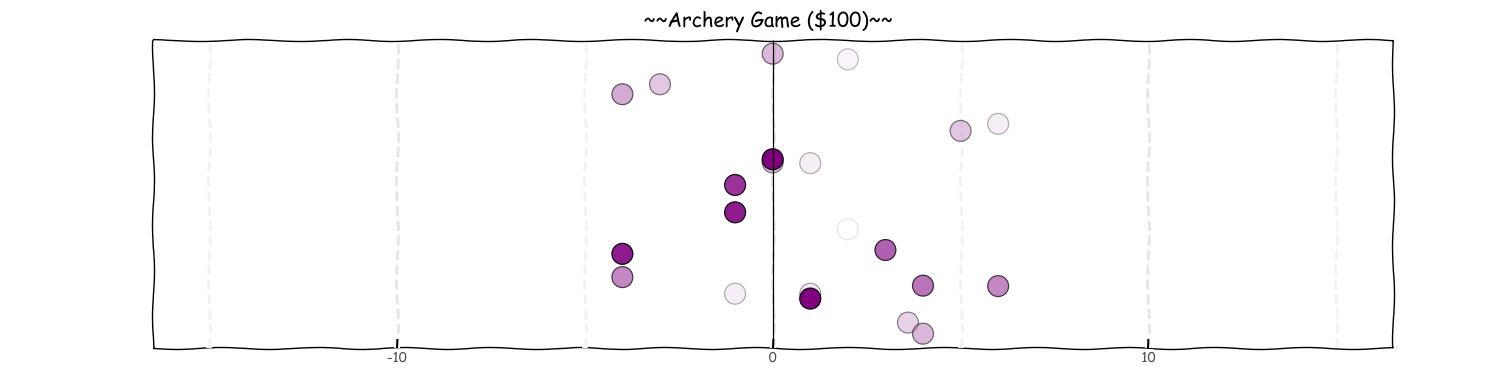

<ggplot: (326058481)>

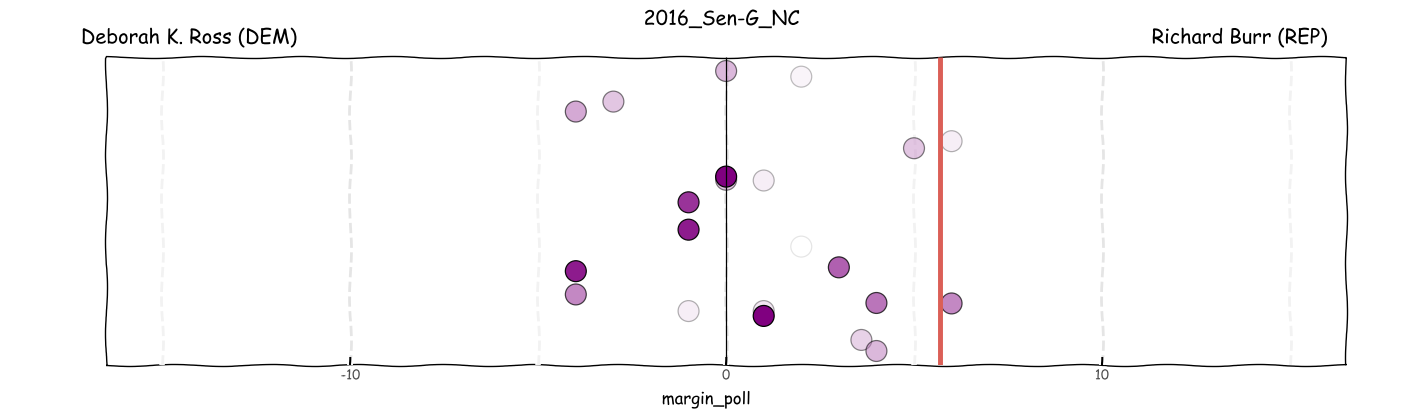

<ggplot: (326498377)>

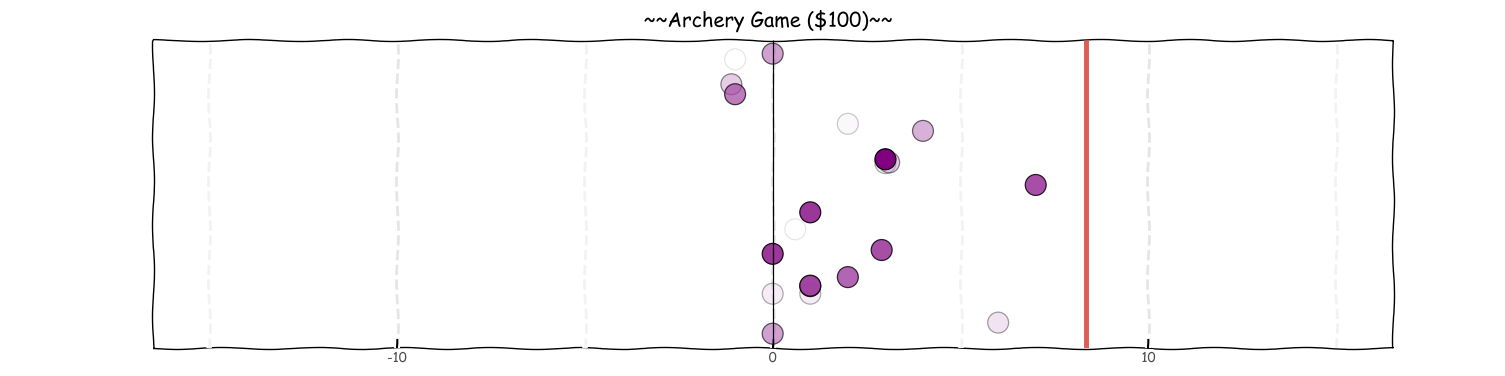

<ggplot: (327398560)>

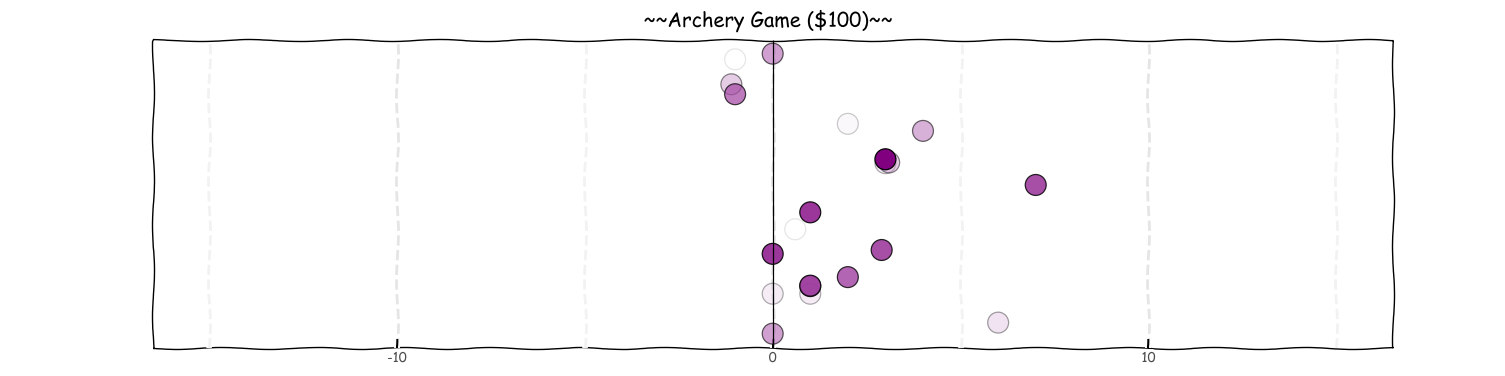

<ggplot: (326290713)>

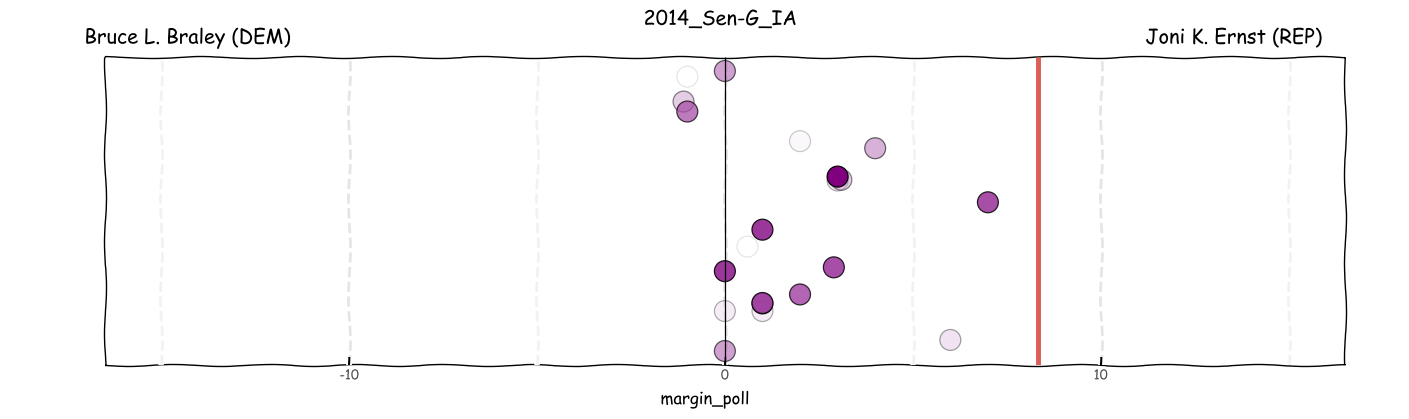

<ggplot: (326261694)>

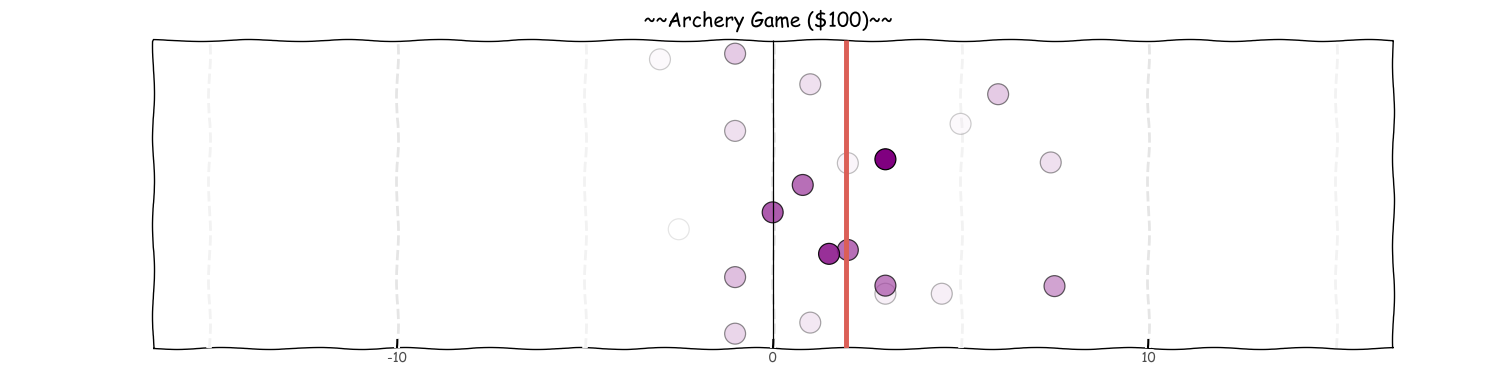

<ggplot: (326966857)>

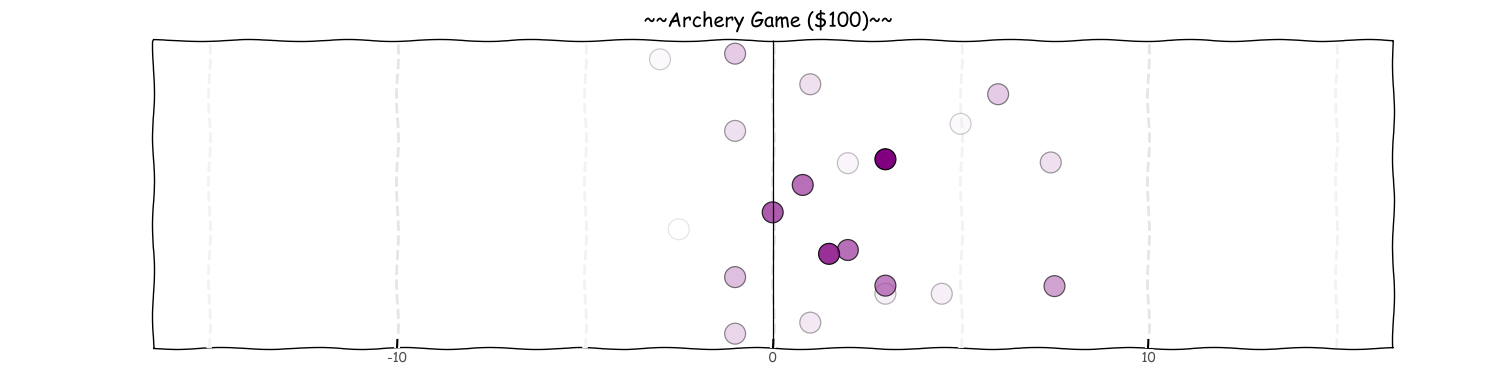

<ggplot: (326514728)>

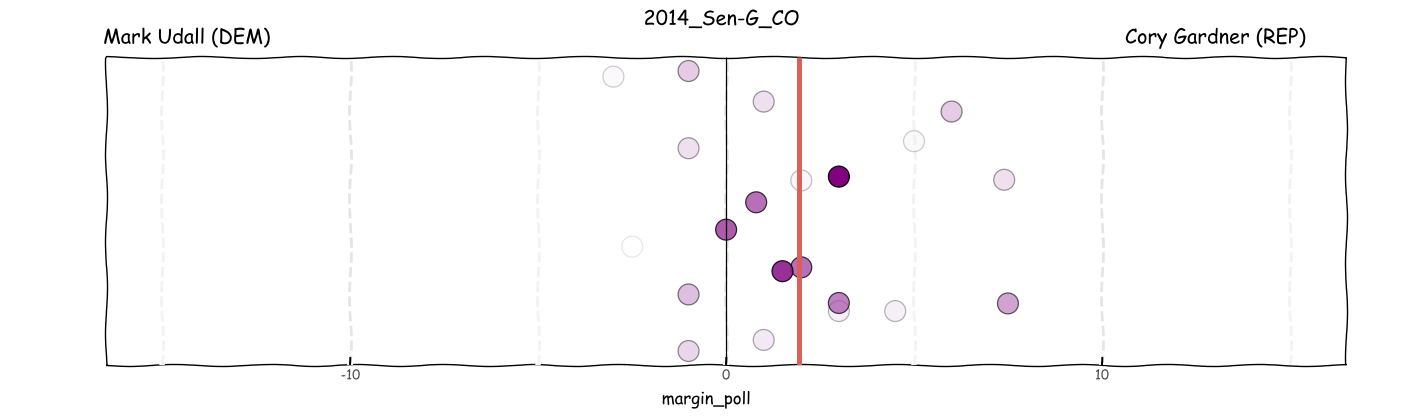

<ggplot: (327029480)>

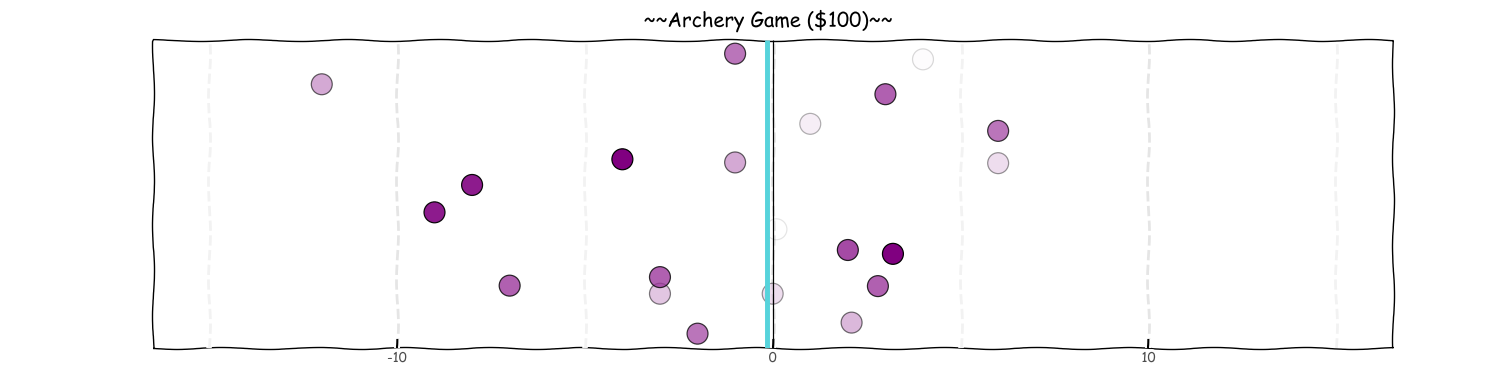

<ggplot: (326098324)>

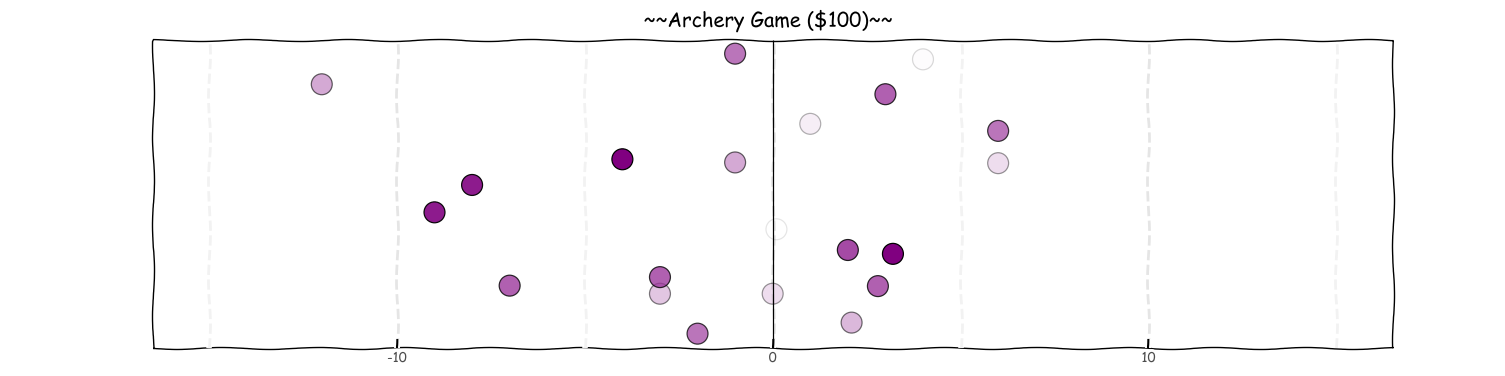

<ggplot: (326599295)>

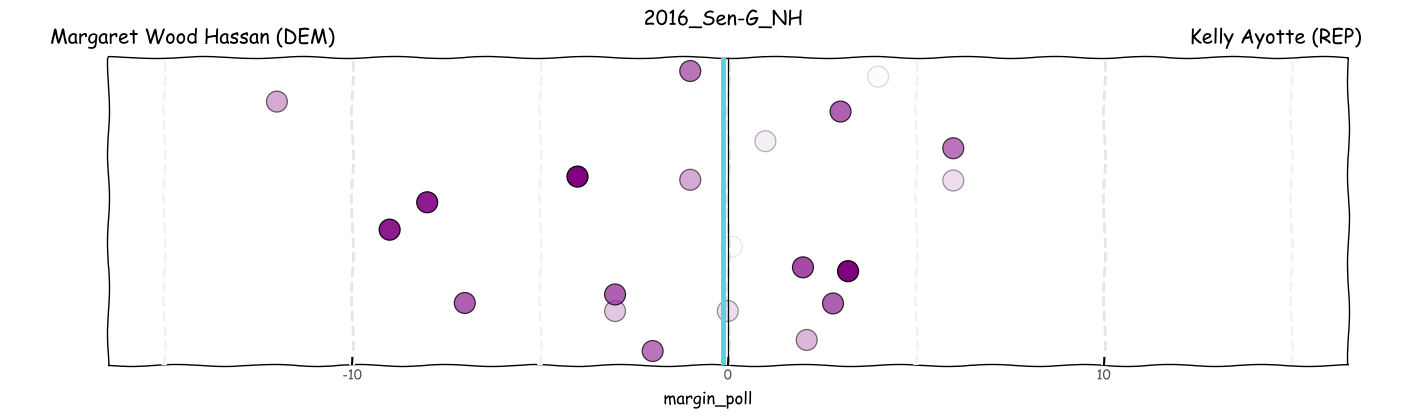

<ggplot: (275903199)>

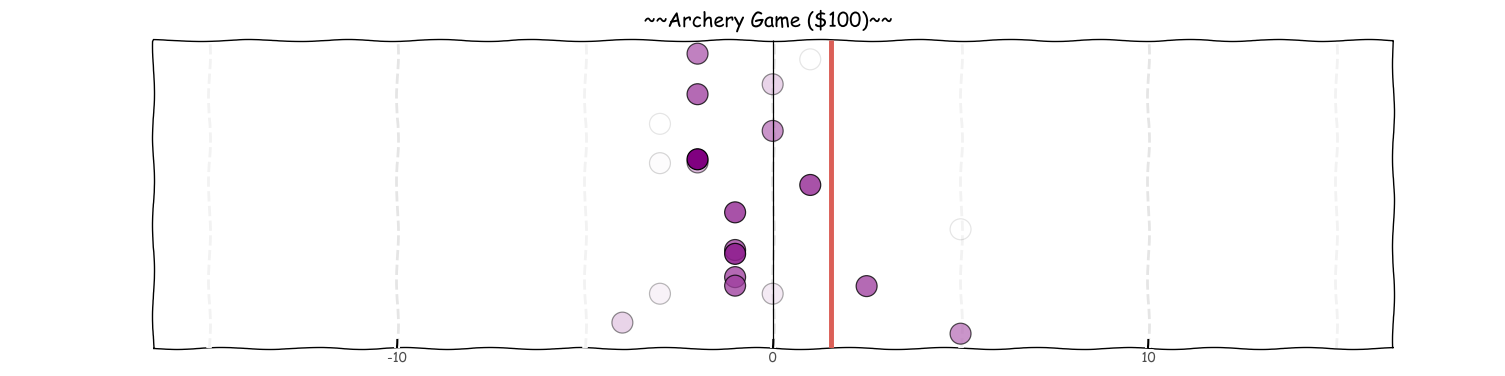

<ggplot: (327375351)>

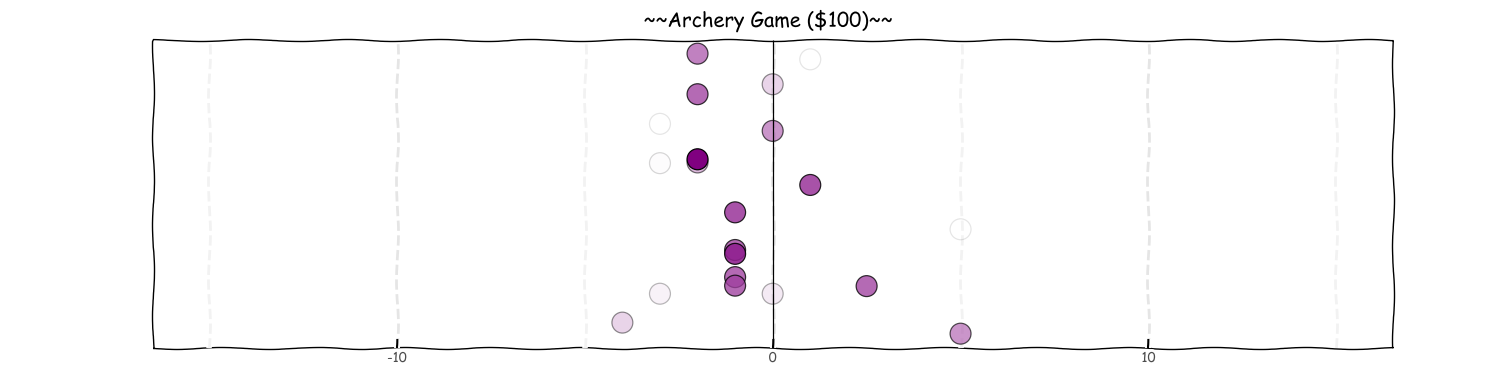

<ggplot: (327169214)>

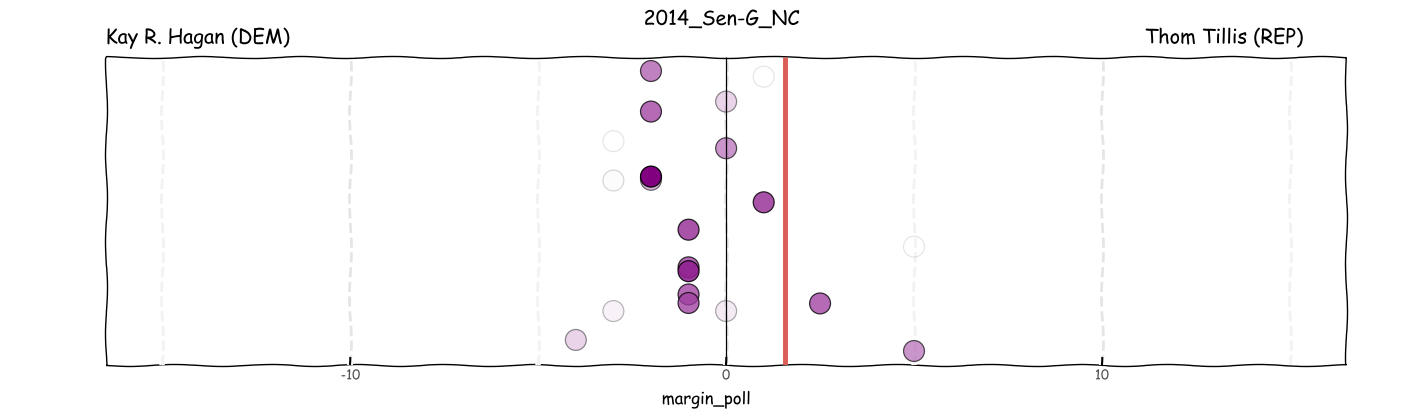

<ggplot: (326018042)>

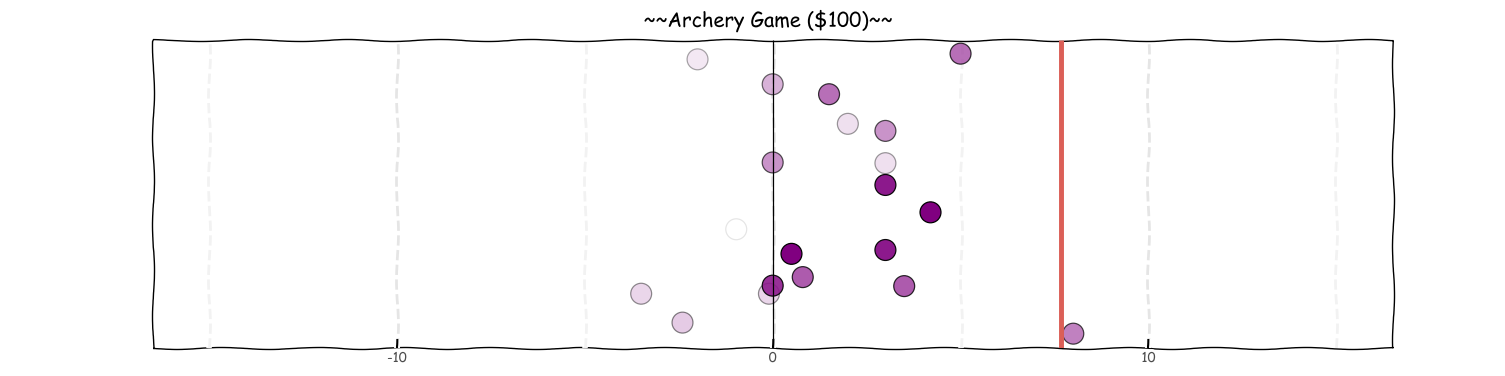

<ggplot: (327217562)>

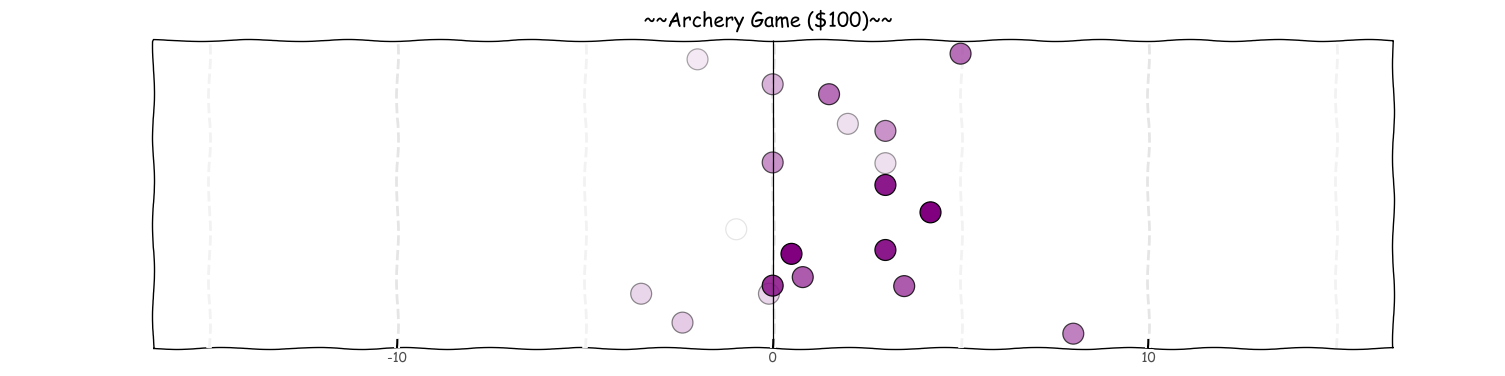

<ggplot: (327187396)>

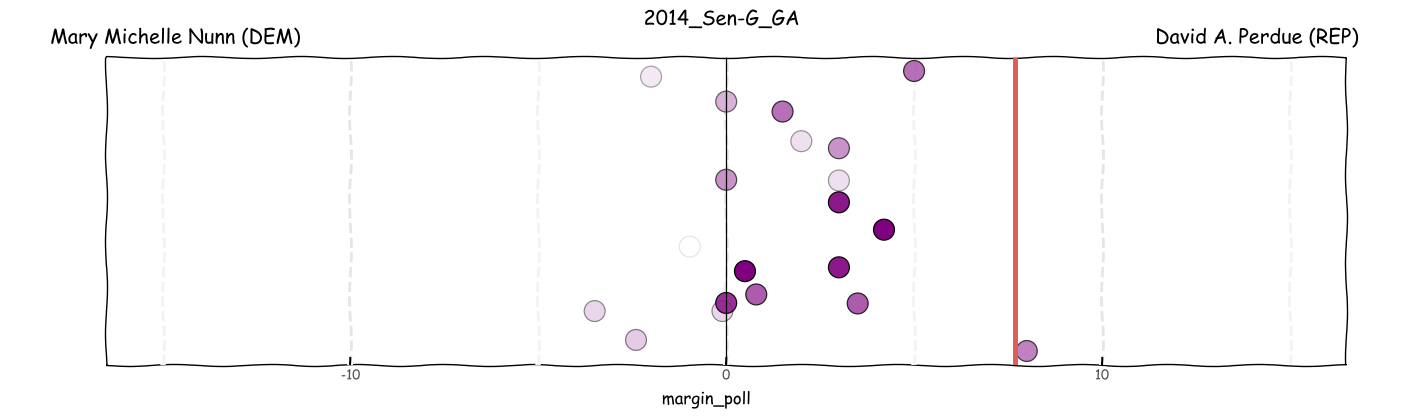

<ggplot: (326217427)>

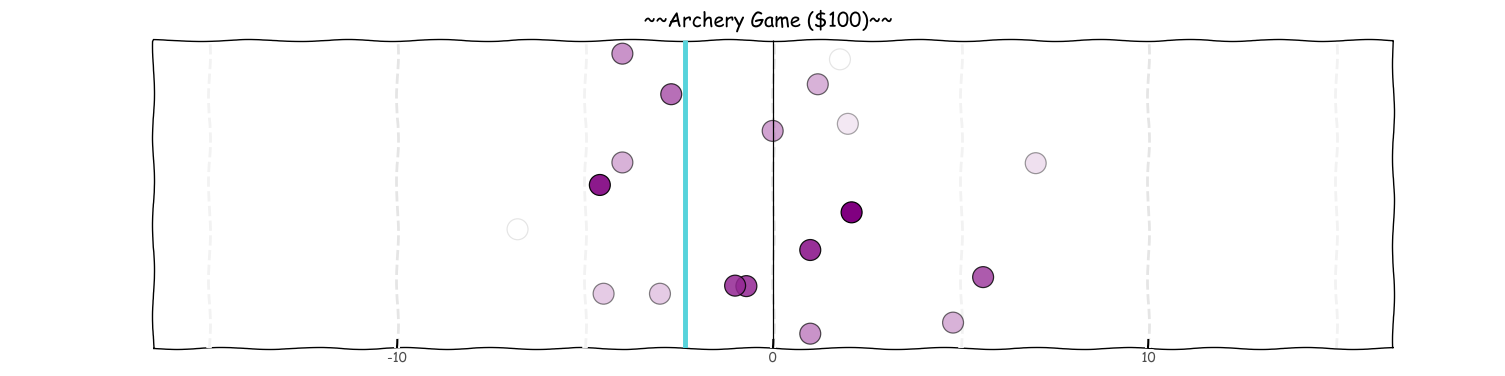

<ggplot: (326713793)>

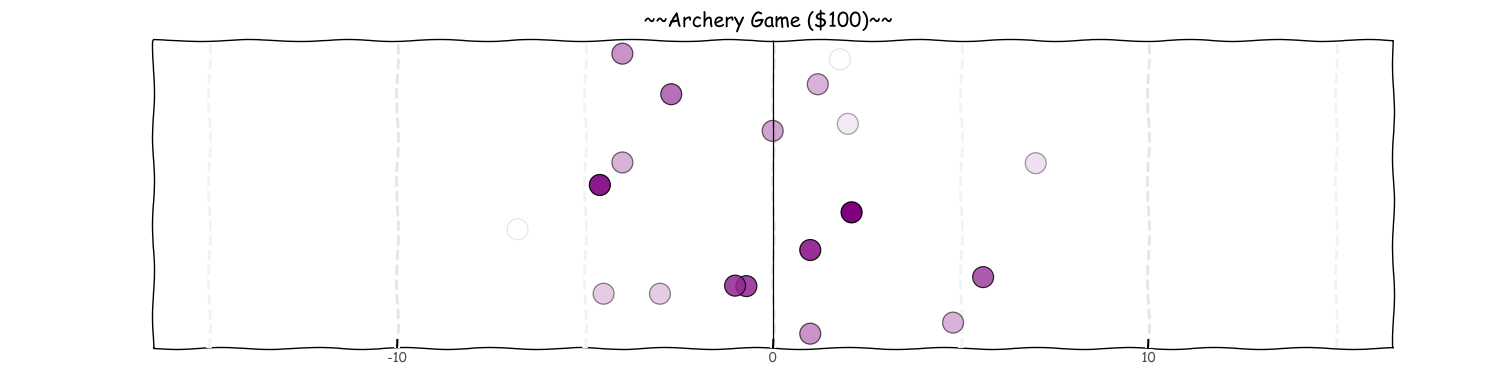

<ggplot: (326257017)>

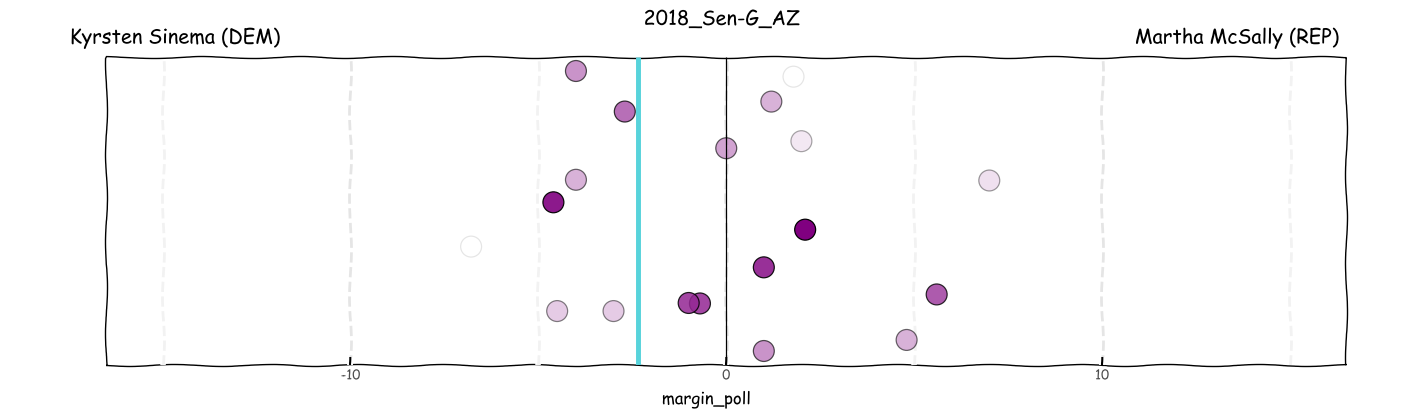

<ggplot: (326641113)>

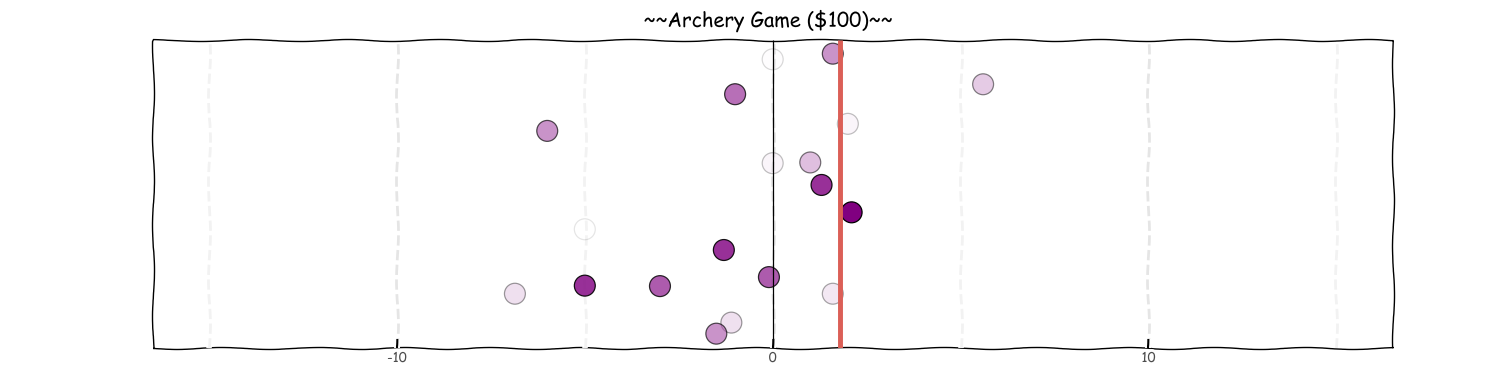

<ggplot: (326498431)>

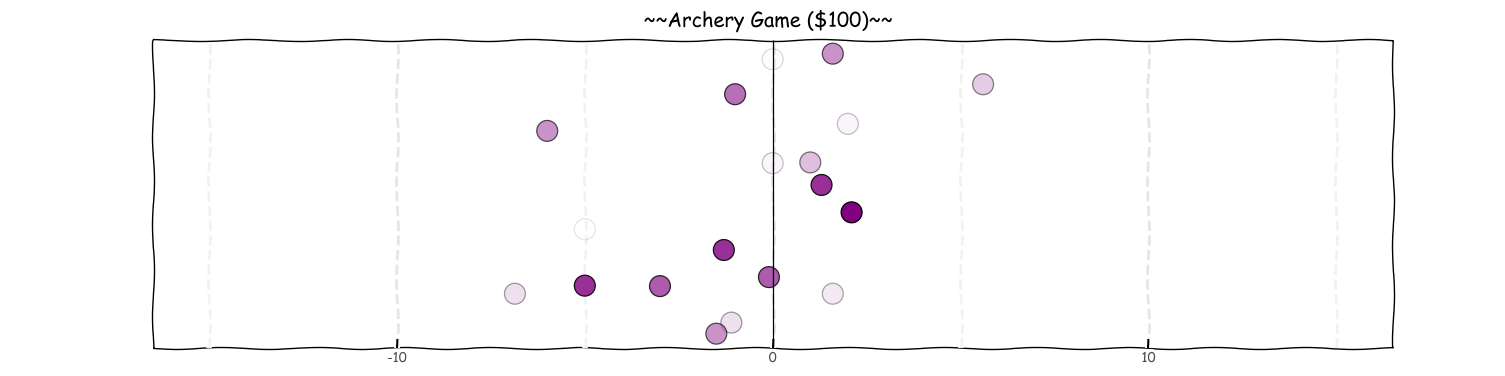

<ggplot: (327029354)>

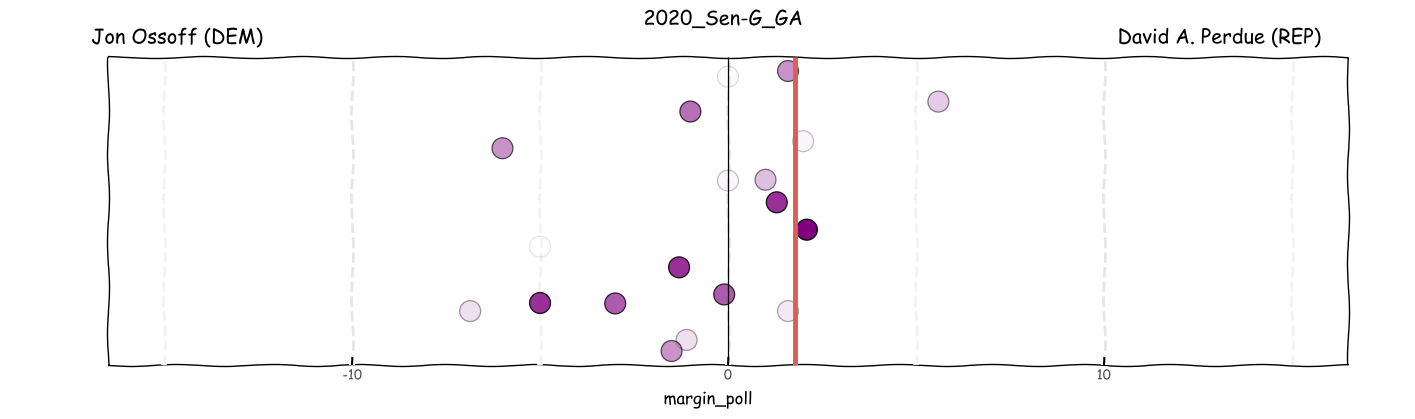

<ggplot: (326263004)>

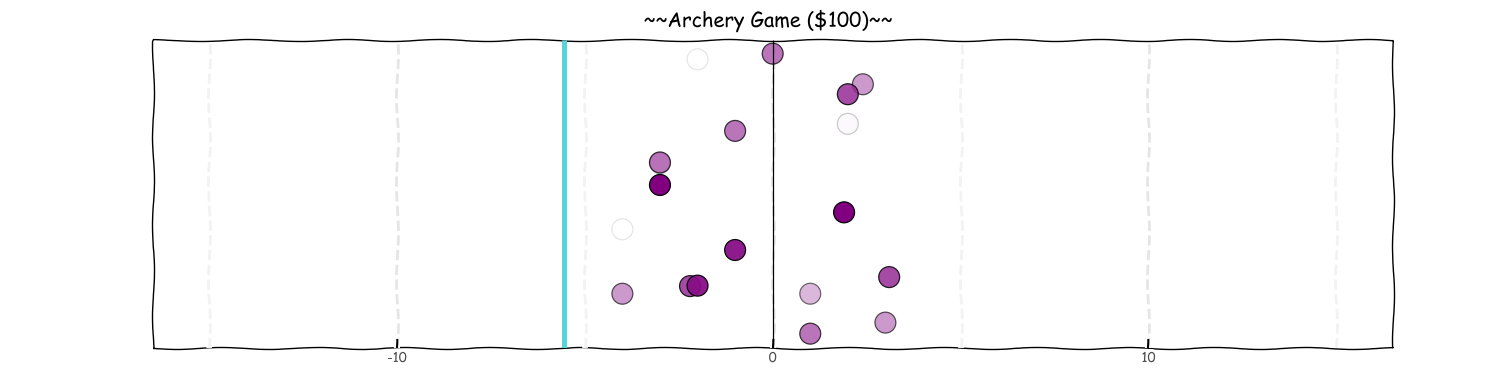

<ggplot: (325865578)>

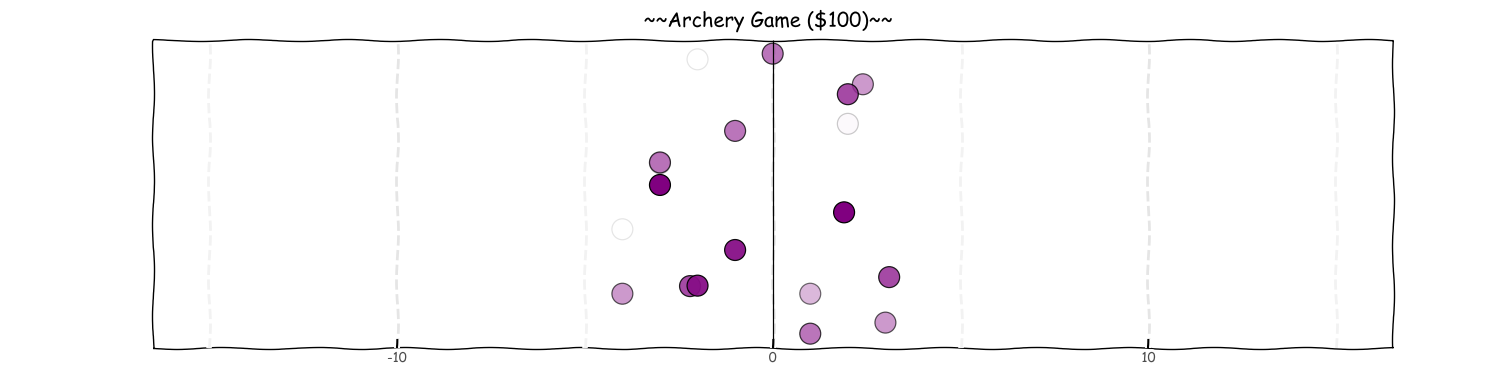

<ggplot: (325662130)>

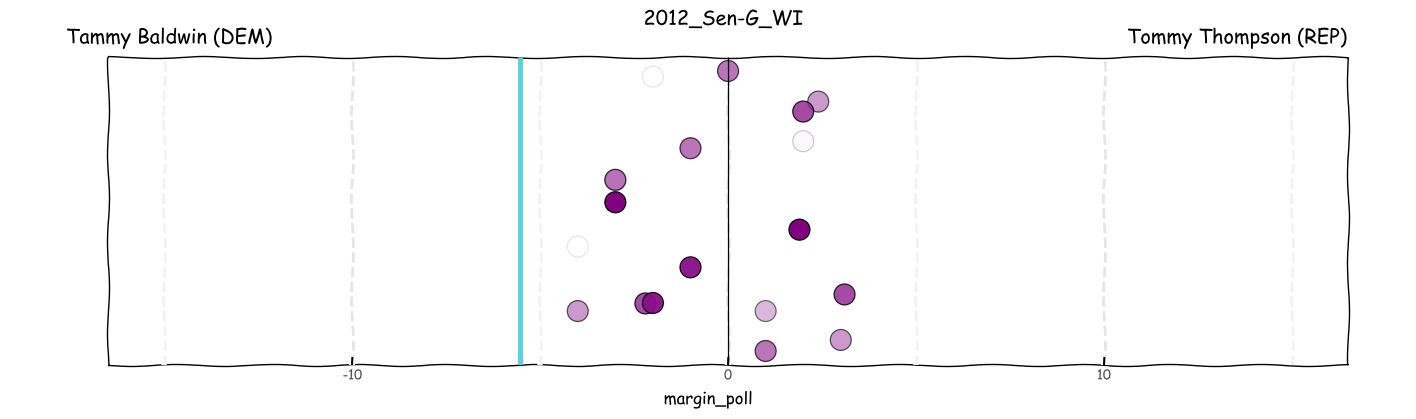

<ggplot: (326609737)>

In [88]:
# QUESTIONS
for a_race in races_of_interest:
#     print(a_race)
    
    polls_for_this_race = polls.query('race == @a_race')
    cand_1 = f"{polls_for_this_race.iloc[0]['cand1_name']} ({polls_for_this_race.iloc[0]['cand1_party']})"
    cand_2 = f"{polls_for_this_race.iloc[0]['cand2_name']} ({polls_for_this_race.iloc[0]['cand2_party']})"
#     print(cand_1)
#     print(cand_2)

    display(
        ggplot(polls.query('race == @a_race'), aes(x='margin_poll', y=1))
     + geom_jitter(aes(width='mose', fill='days_until_election', alpha='days_until_election'), size=8,width=0, height=.2, random_state=42)
#          + geom_point(data=polls_to_analyze.pivot_table(index='year', aggfunc='mean', values='margin_poll').reset_index(), shape='x', size=8) 
         + geom_vline(aes(xintercept='margin_actual', color="winner_party"), size=2)
#          + geom_rect(aes(xmax=2.5,xmin=-2.5, ymax=float('inf'), ymin=float('-inf')), fill='grey', alpha=.005)
         + geom_vline(aes(xintercept=0))
         + xlim(-15,15)
         + p9.scale_fill_gradient(low="white",high="purple", values=[-21,0])
         + labs(title=f'                                                                                                          ~~Archery Game ($100)~~                                                                                                    ',
               y='', x='')
         + theme_xkcd()
         + theme(figure_size=(16, 4),
                legend_position='none',
                axis_text_y= element_blank(), axis_line_y= element_blank(),
                axis_title_y=element_blank(), axis_ticks_minor_y=element_blank(), axis_ticks_major_y=element_blank(),
                panel_grid_major_x = element_line(color='grey', size=2, linetype='dashed', alpha=.2),
                panel_grid_minor_x = element_line(color='grey', size=2, linetype='dashed', alpha=.1),
                panel_border=element_rect(color='black', size=1)) 
    )

    display(
        ggplot(polls.query('race == @a_race'), aes(x='margin_poll', y=1))
     + geom_jitter(aes(width='mose', fill='days_until_election', alpha='days_until_election'), size=8,width=0, height=.2, random_state=42)
#          + geom_point(data=polls_to_analyze.pivot_table(index='year', aggfunc='mean', values='margin_poll').reset_index(), shape='x', size=8) 
#          + geom_vline(aes(xintercept='margin_actual', color="winner_party"), size=2)
#          + geom_rect(aes(xmax=2.5,xmin=-2.5, ymax=float('inf'), ymin=float('-inf')), fill='grey', alpha=.005)
         + geom_vline(aes(xintercept=0))
         + xlim(-15,15)
         + p9.scale_fill_gradient(low="white",high="purple", values=[-21,0])
         + labs(title=f'                                                                                                          ~~Archery Game ($100)~~                                                                                                    ',
               y='', x='')
         + theme_xkcd()
         + theme(figure_size=(16, 4),
                legend_position='none',
                axis_text_y= element_blank(), axis_line_y= element_blank(),
                axis_title_y=element_blank(), axis_ticks_minor_y=element_blank(), axis_ticks_major_y=element_blank(),
                panel_grid_major_x = element_line(color='grey', size=2, linetype='dashed', alpha=.2),
                panel_grid_minor_x = element_line(color='grey', size=2, linetype='dashed', alpha=.1),
                panel_border=element_rect(color='black', size=1)) 
    )


    display(
        ggplot(polls.query('race == @a_race'), aes(x='margin_poll', y='1'))
     + geom_jitter(aes(width='mose', fill='days_until_election', alpha='days_until_election'), size=8,width=0, height=.2, random_state=42)
#          + geom_point(data=polls_to_analyze.pivot_table(index='year', aggfunc='mean', values='margin_poll').reset_index(), shape='x', size=8) 
         + geom_vline(aes(xintercept='margin_actual', color="winner_party"), size=2)
         + geom_vline(aes(xintercept=0))
         + theme_xkcd()
         + theme(figure_size=(16, 4),
                legend_position='none',
                axis_text_y= element_blank(), axis_line_y= element_blank(),
                axis_title_y=element_blank(), 
                axis_ticks_minor_y=element_blank(), axis_ticks_major_y=element_blank(),
                panel_grid_major_x = element_line(color='grey', size=2, linetype='dashed', alpha=.2),
                panel_grid_minor_x = element_line(color='grey', size=2, linetype='dashed', alpha=.1),
                panel_border=element_rect(color='black', size=1)) 
         + xlim(-15,15)
         + p9.scale_fill_gradient(low="white",high="purple", values=[-21,0])
         + labs(title=f'                                                                                                          {a_race}                                                                                                    ' +
                      f'\n{cand_1}                                                                                                                                               {cand_2}' )
    )


In [13]:
years = polls_to_analyze.year.unique()
np.random.shuffle(years)
year = years[0]

In [14]:
year = 2016
polls_to_analyze.query('year==@year').type_simple.unique()

array(['Pres-G'], dtype=object)

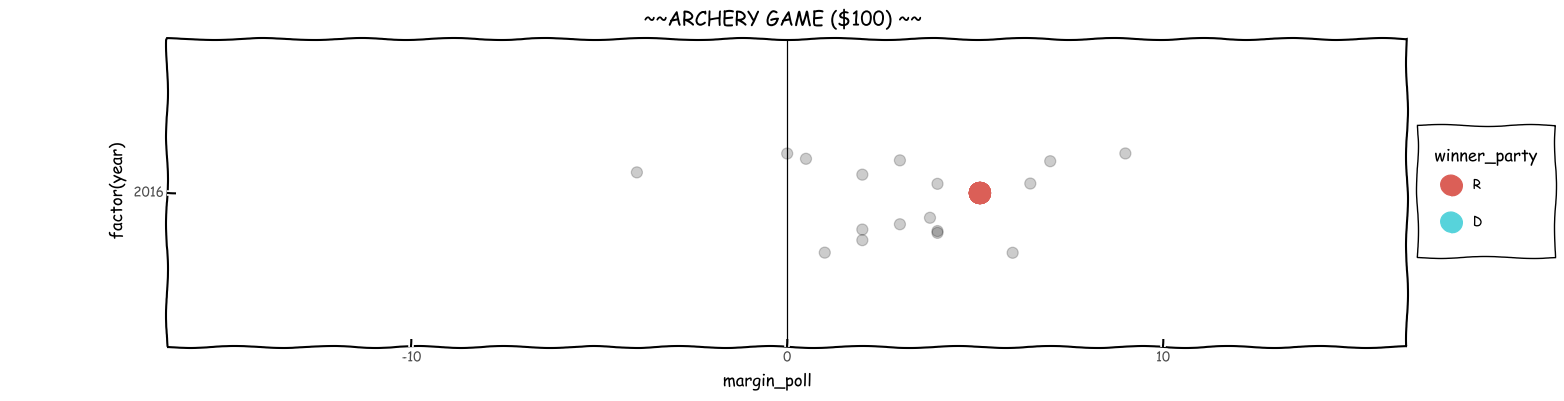

<ggplot: (326669891)>

In [15]:
display(
    ggplot(polls_to_analyze.query('year==@year'), aes(x='margin_poll', y='factor(year)'))
     + geom_jitter(size=4, alpha=.2, width=0, height=.2)
#      + geom_point(data=polls_to_analyze.pivot_table(index='year', aggfunc='mean', values='margin_poll').reset_index(), shape='x', size=8) 
     + geom_point(aes(x='margin_actual', color="winner_party"), size=8)
     + geom_vline(aes(xintercept=0))
     + theme_xkcd()
     + theme(figure_size=(16, 4)) 
     + xlim(-15,15)
     + labs(title='                                                                                                          ~~ARCHERY GAME ($100) ~~                                                                                                    ')
)

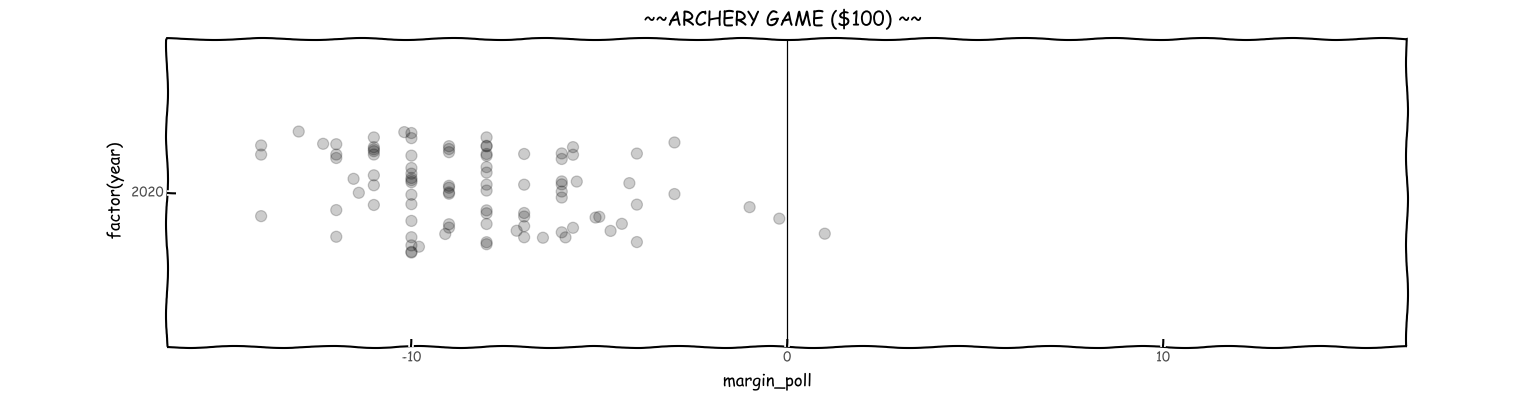

<ggplot: (337341907)>

In [80]:
display(
    ggplot(polls_to_analyze.query('year==2020'), aes(x='margin_poll', y='factor(year)'))
     + geom_jitter(size=4, alpha=.2, width=0, height=.2)
#      + geom_point(data=polls_to_analyze.pivot_table(index='year', aggfunc='mean', values='margin_poll').reset_index(), shape='x', size=8) 
#      + geom_point(aes(x='margin_actual', color="winner_party"), size=8)
     + geom_vline(aes(xintercept=0))
     + theme_xkcd()
     + theme(figure_size=(16, 4)) 
     + xlim(-15,15)
     + labs(title='                                                                                                          ~~ARCHERY GAME ($100) ~~                                                                                                    ')
)

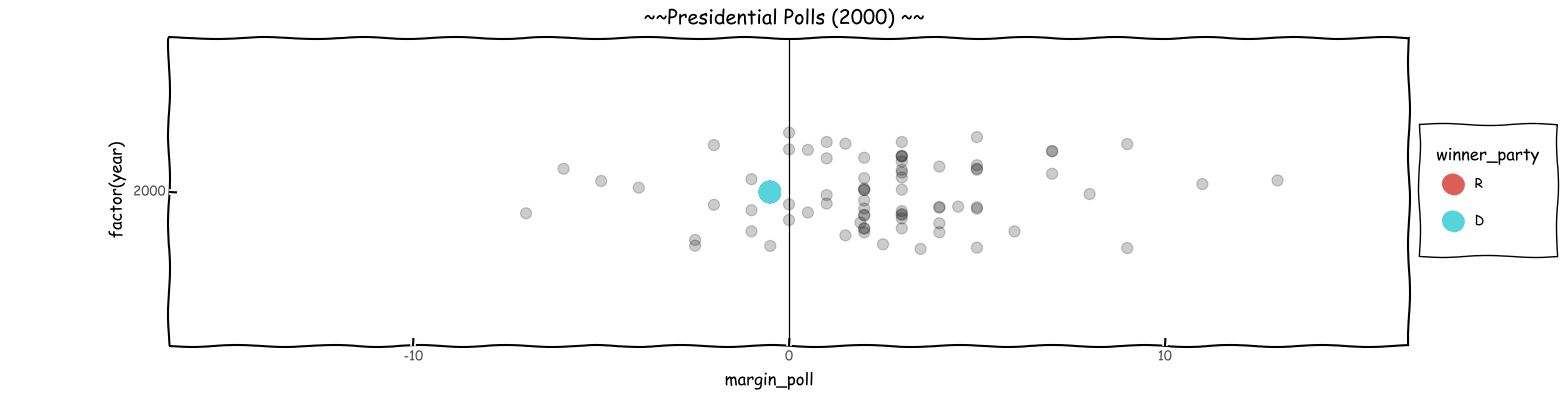

<ggplot: (337593691)>

In [77]:
display(
    ggplot(polls_to_analyze.query('year==@year'), aes(x='margin_poll', y='factor(year)'))
     + geom_jitter(size=4, alpha=.2, width=0, height=.2)
#      + geom_point(data=polls_to_analyze.pivot_table(index='year', aggfunc='mean', values='margin_poll').reset_index(), shape='x', size=8) 
     + geom_point(aes(x='margin_actual', color="winner_party"), size=8)
     + geom_vline(aes(xintercept=0))
     + theme_xkcd()
     + theme(figure_size=(16, 4)) 
     + xlim(-15,15)
     + labs(title=f'                                                                                                          ~~Presidential Polls ({year}) ~~                                                                                                    ')
)

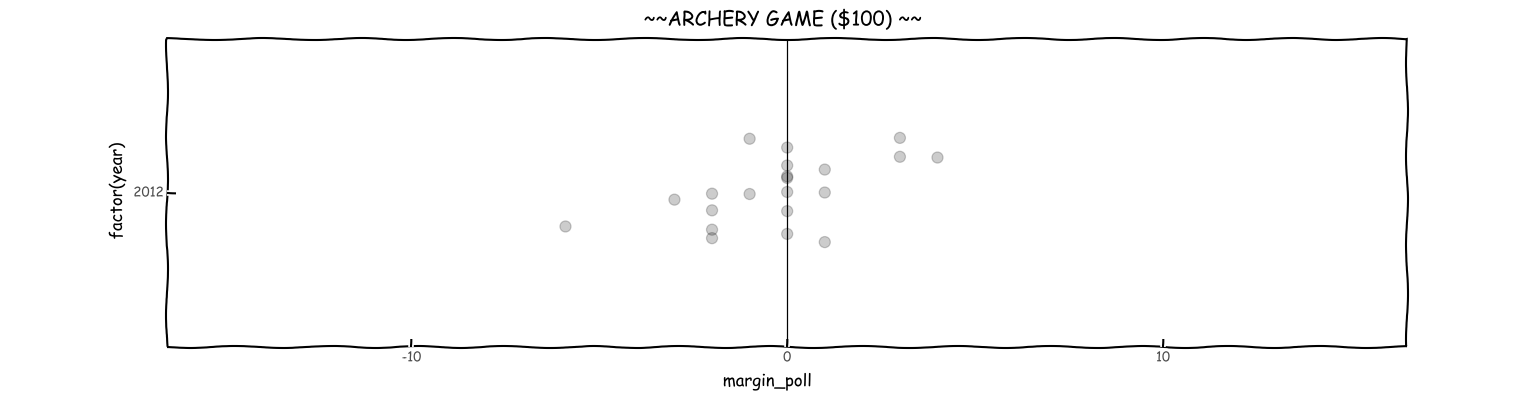

<ggplot: (337760461)>

In [40]:
LEFT PERSON, RIGHT PERSON
BET - $60 TO THE LEFT
"MAJORITY OF POLLS CURRENTLY CONDUCTED SEEM TO INDICATE THAT LEFT PERSON WILL WIN"




display(
    ggplot(polls_to_analyze.query('year==@year'), aes(x='margin_poll', y='factor(year)'))
     + geom_jitter(size=4, alpha=.2, width=0, height=.2)
#      + geom_point(data=polls_to_analyze.pivot_table(index='year', aggfunc='mean', values='margin_poll').reset_index(), shape='x', size=8) 
#      + geom_point(aes(x='margin_actual', color="winner_party"), size=8)
     + geom_vline(aes(xintercept=0))
     + theme_xkcd()
     + theme(figure_size=(16, 4)) 
     + xlim(-15,15)
     + labs(title='                                                                                                          ~~ARCHERY GAME ($100) ~~                                                                                                    ')
)

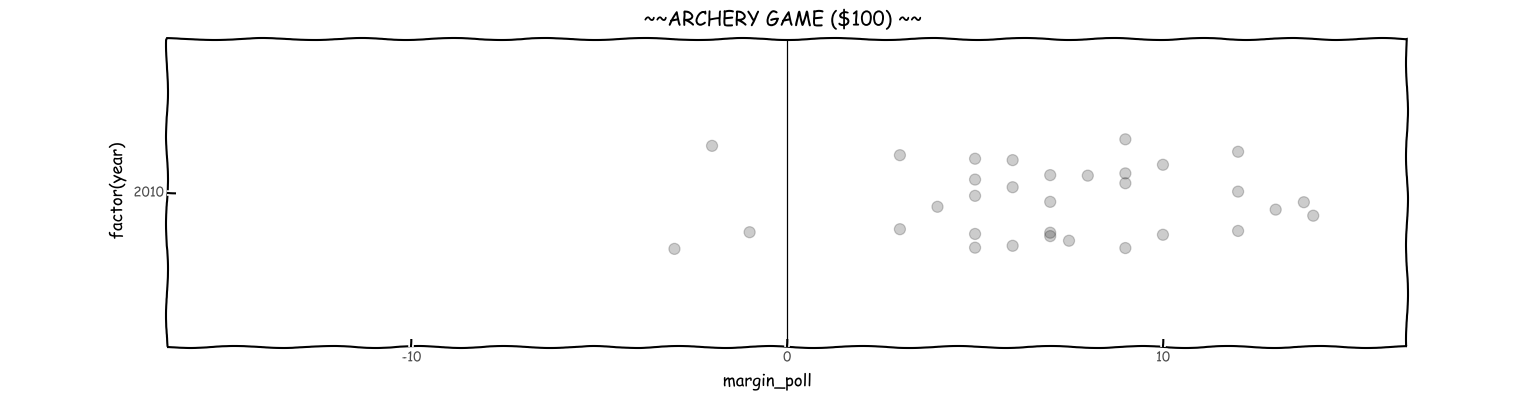

<ggplot: (337679225)>

In [39]:
display(
    ggplot(polls_to_analyze.query('year==2010'), aes(x='margin_poll', y='factor(year)'))
     + geom_jitter(size=4, alpha=.2, width=0, height=.2)
#      + geom_point(data=polls_to_analyze.pivot_table(index='year', aggfunc='mean', values='margin_poll').reset_index(), shape='x', size=8) 
#      + geom_point(aes(x='margin_actual', color="winner_party"), size=8)
     + geom_vline(aes(xintercept=0))
     + theme_xkcd()
     + theme(figure_size=(16, 4)) 
     + xlim(-15,15)
     + labs(title='                                                                                                          ~~ARCHERY GAME ($100) ~~                                                                                                    ')
)

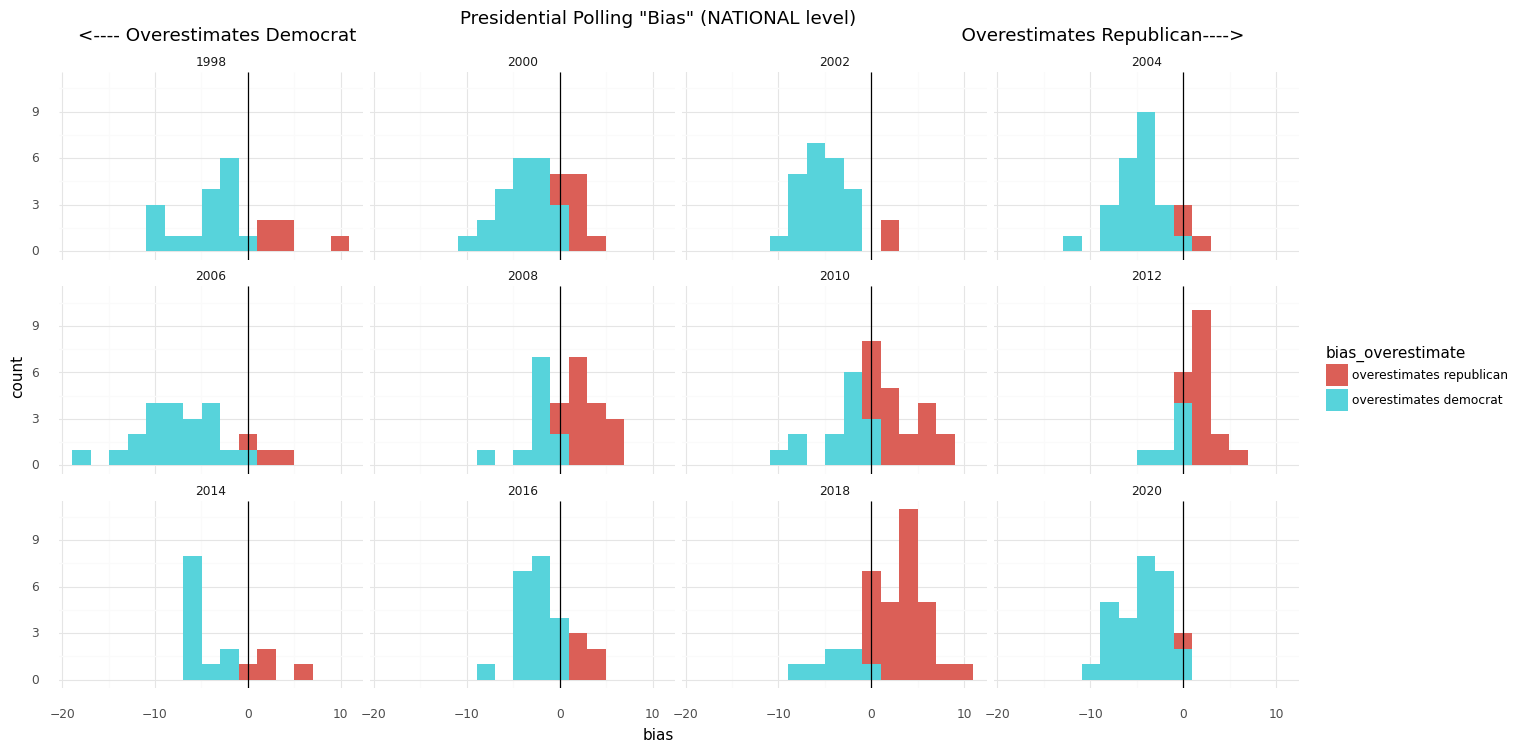

<ggplot: (346529681)>

In [141]:
# Here is another view
(
    ggplot(polls_to_analyze, aes(x='bias', fill='bias_overestimate'))
     + geom_histogram()
     + geom_vline(aes(xintercept=0))
     + theme_minimal()
     + facet_wrap('~year')
     + theme(figure_size=(16, 8)) 
     + labs(title='Presidential Polling "Bias" (NATIONAL level)\n <---- Overestimates Democrat                                                                                                       Overestimates Republican---->')

)

KeyError: 'House-G'

In [114]:
polls_to_analyze.pivot_table(index='year',values='margin_poll')

margin_poll
year             
2000     2.452000
2004     1.543077
2008    -7.281319
2012    -0.417294
2016    -3.652308
2020    -8.279681

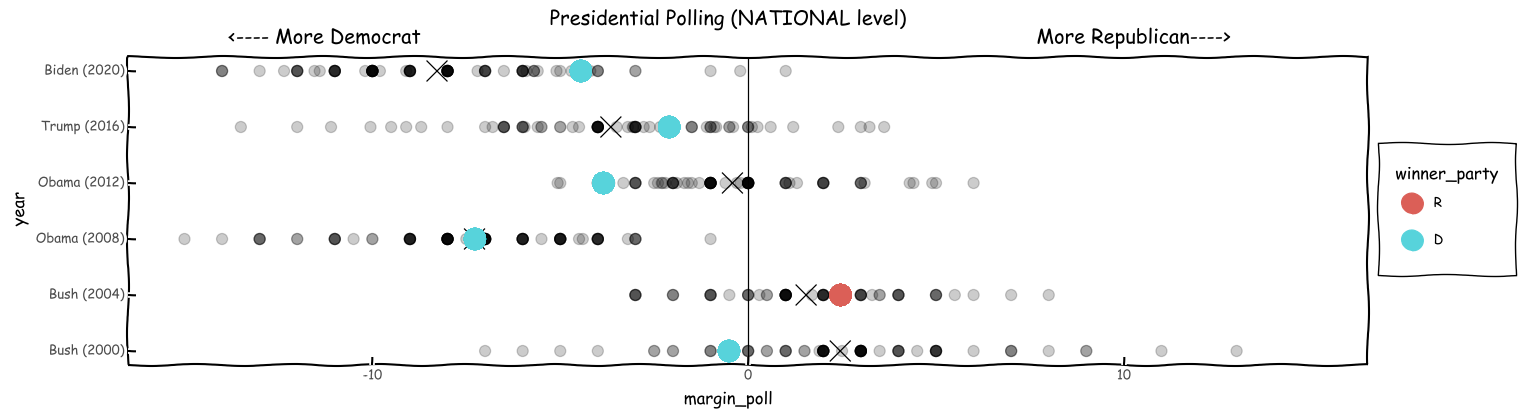

<ggplot: (346650944)>

In [115]:
display(
    ggplot(polls_to_analyze, aes(x='margin_poll', y='year'))
     + geom_point(size=4, alpha=.2)
     + geom_point(data=polls_to_analyze.pivot_table(index='year', aggfunc='mean', values='margin_poll').reset_index(), shape='x', size=8) 
     + geom_point(aes(x='margin_actual', color="winner_party"), size=8)
     + geom_vline(aes(xintercept=0))
     + scale_y_continuous(breaks=list(range(2000,2024,4)), 
                          labels=list(reversed(['Biden (2020)', 'Trump (2016)', 'Obama (2012)', 'Obama (2008)', 'Bush (2004)', 'Bush (2000)'])))
     + theme_xkcd()
     + theme(figure_size=(16, 4)) 
     + xlim(-15,15)
     + labs(title='Presidential Polling (NATIONAL level)\n <---- More Democrat                                                                                                       More Republican---->')
)

# Plotting "bias" rather than margin, since we care about how far off the poll was from the actual result
# display( 
#     ggplot(polls_to_analyze, aes(x='bias', y='year'))
#      + geom_point(size=4, alpha=.2)
#      + geom_point(data=polls_to_analyze.pivot_table(index='year', aggfunc='mean', values='bias').reset_index(), shape='x', size=8) 
#      + geom_point(aes(x=0, color="winner_party"), size=8)
#      + geom_vline(aes(xintercept=0))
#      + scale_y_continuous(breaks=list(range(2000,2024,4)), 
#                           labels=list(reversed(['Biden (2020)', 'Trump (2016)', 'Obama (2012)', 'Obama (2008)', 'Bush (2004)', 'Bush (2000)'])))
#      + theme_xkcd()
#      + xlim(-15,15)
#      + theme(figure_size=(16, 4)) 
#      + labs(title='Presidential Polling "Bias" (NATIONAL level)\n <---- Overestimates Democrat                                                                                                       Overestimates Republican---->')

# )

### What do you notice about this chart?

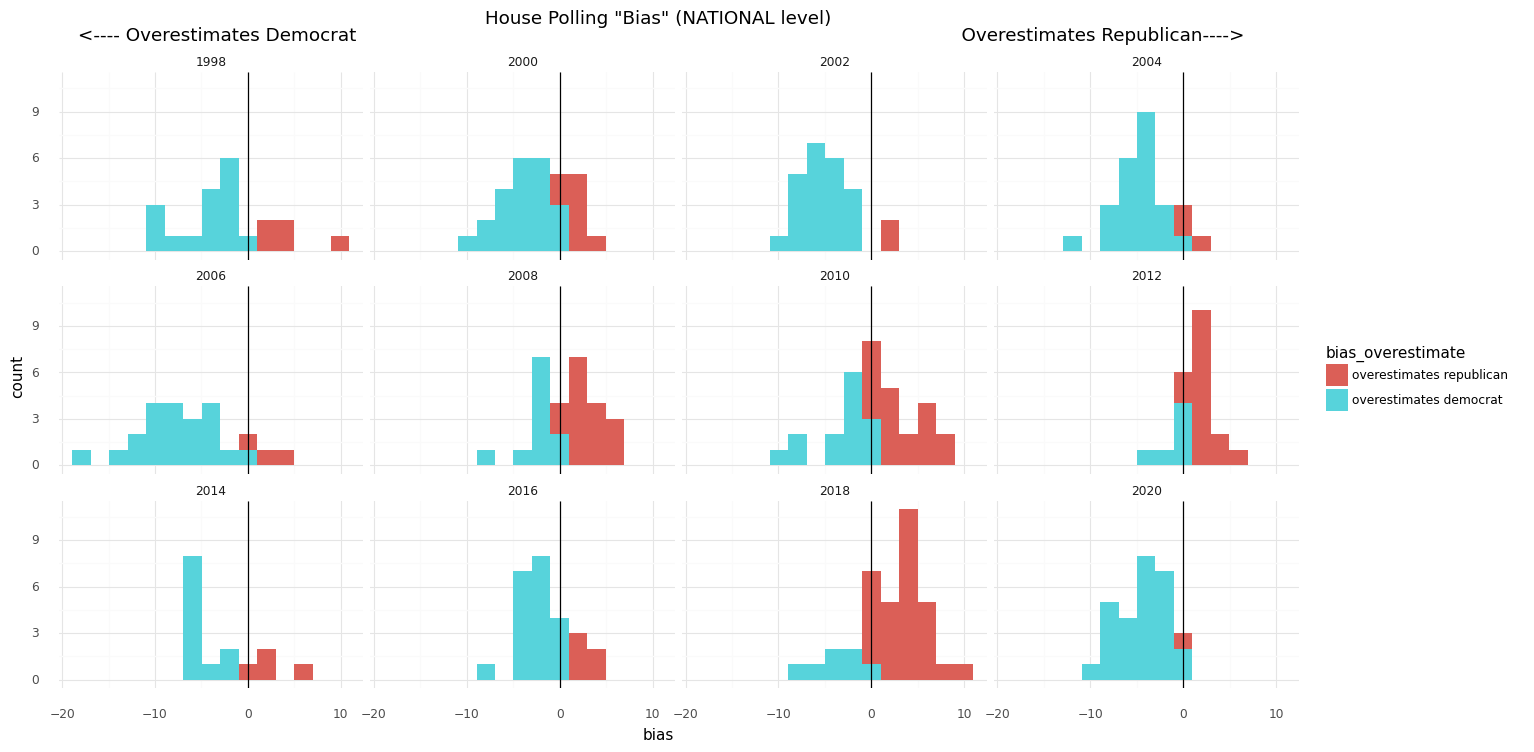

<ggplot: (338271738)>

In [142]:
# Here is another view
(
    ggplot(polls_to_analyze, aes(x='bias', fill='bias_overestimate'))
     + geom_histogram()
     + geom_vline(aes(xintercept=0))
     + theme_minimal()
     + facet_wrap('~year')
     + theme(figure_size=(16, 8)) 
     + labs(title='House Polling "Bias" (NATIONAL level)\n <---- Overestimates Democrat                                                                                                       Overestimates Republican---->')

)

### What have we noticed about the presidential polls at the national level?

<details><summary> ---> DON'T CLICK ME </summary>
<p>

* Even if MoE Is +/-3 for example, in practice there are other sources of error. Histoircally polls have been more like +/-5 pts on average.
* Polls sometimes miss in the same direction in any given year.
```

</p>
</details>

### How might this impact how you report on a new poll that comes out?



<details><summary> ---> DON'T CLICK ME </summary>
<p>

* Place individual polls in their aggregate context
* Convey uncertainty appropriately

</p>
</details>

## But, we don't have one Presidential election in the U.S. ... 
...we have 50 separate ones (plus DC and some quirks in Maine and Nebraska). And the nationwide polls can only tell us so much about who might win the election. So what about state polling? Has it been getting better or worse over the years? Can we still rely on it this coming election cycle? 


In [117]:
# A quick look at the polls dataframe
presidential_state_level_polls = polls.query("type_detail=='Pres-G' and location!='US'")
presidential_state_level_polls.head(2)

poll_id  question_id  race_id  year            race location type_simple  \
471     6483         7952      815  2000  2000_Pres-G_FL       FL      Pres-G   
472     6470         7939      820  2000  2000_Pres-G_IL       IL      Pres-G   

    type_detail                 pollster  pollster_rating_id methodology  \
471      Pres-G  McLaughlin & Associates                 203  Live Phone   
472      Pres-G             KRC Research                 160  Live Phone   

    partisan    polldate  samplesize cand1_name  cand1_id cand1_party  \
471        R  10/17/2000       600.0    Al Gore       222         DEM   
472      NaN  10/17/2000       600.0    Al Gore       222         DEM   

     cand1_pct      cand2_name  cand2_id cand2_party  cand2_pct  cand3_pct  \
471       43.0  George W. Bush       241         REP       44.0        3.0   
472       45.0  George W. Bush       241         REP       43.0        4.0   

     margin_poll electiondate  cand1_actual  cand2_actual  margin_actual  \
471          1.0    11/7/2000         48.84         48.85           0.01   
472         -2.0    11/7/2000         54.60         42.58         -12.01   

     error   bias  rightcall  advancedplusminus            comment  \
471   0.99   0.99        1.0          -3.534693  for Bill McCollum   
472  10.01  10.01        1.0           3.420487                NaN   

            bias_overestimate national winner_party  
471  overestimates republican    state            R  
472  overestimates republican    state            D

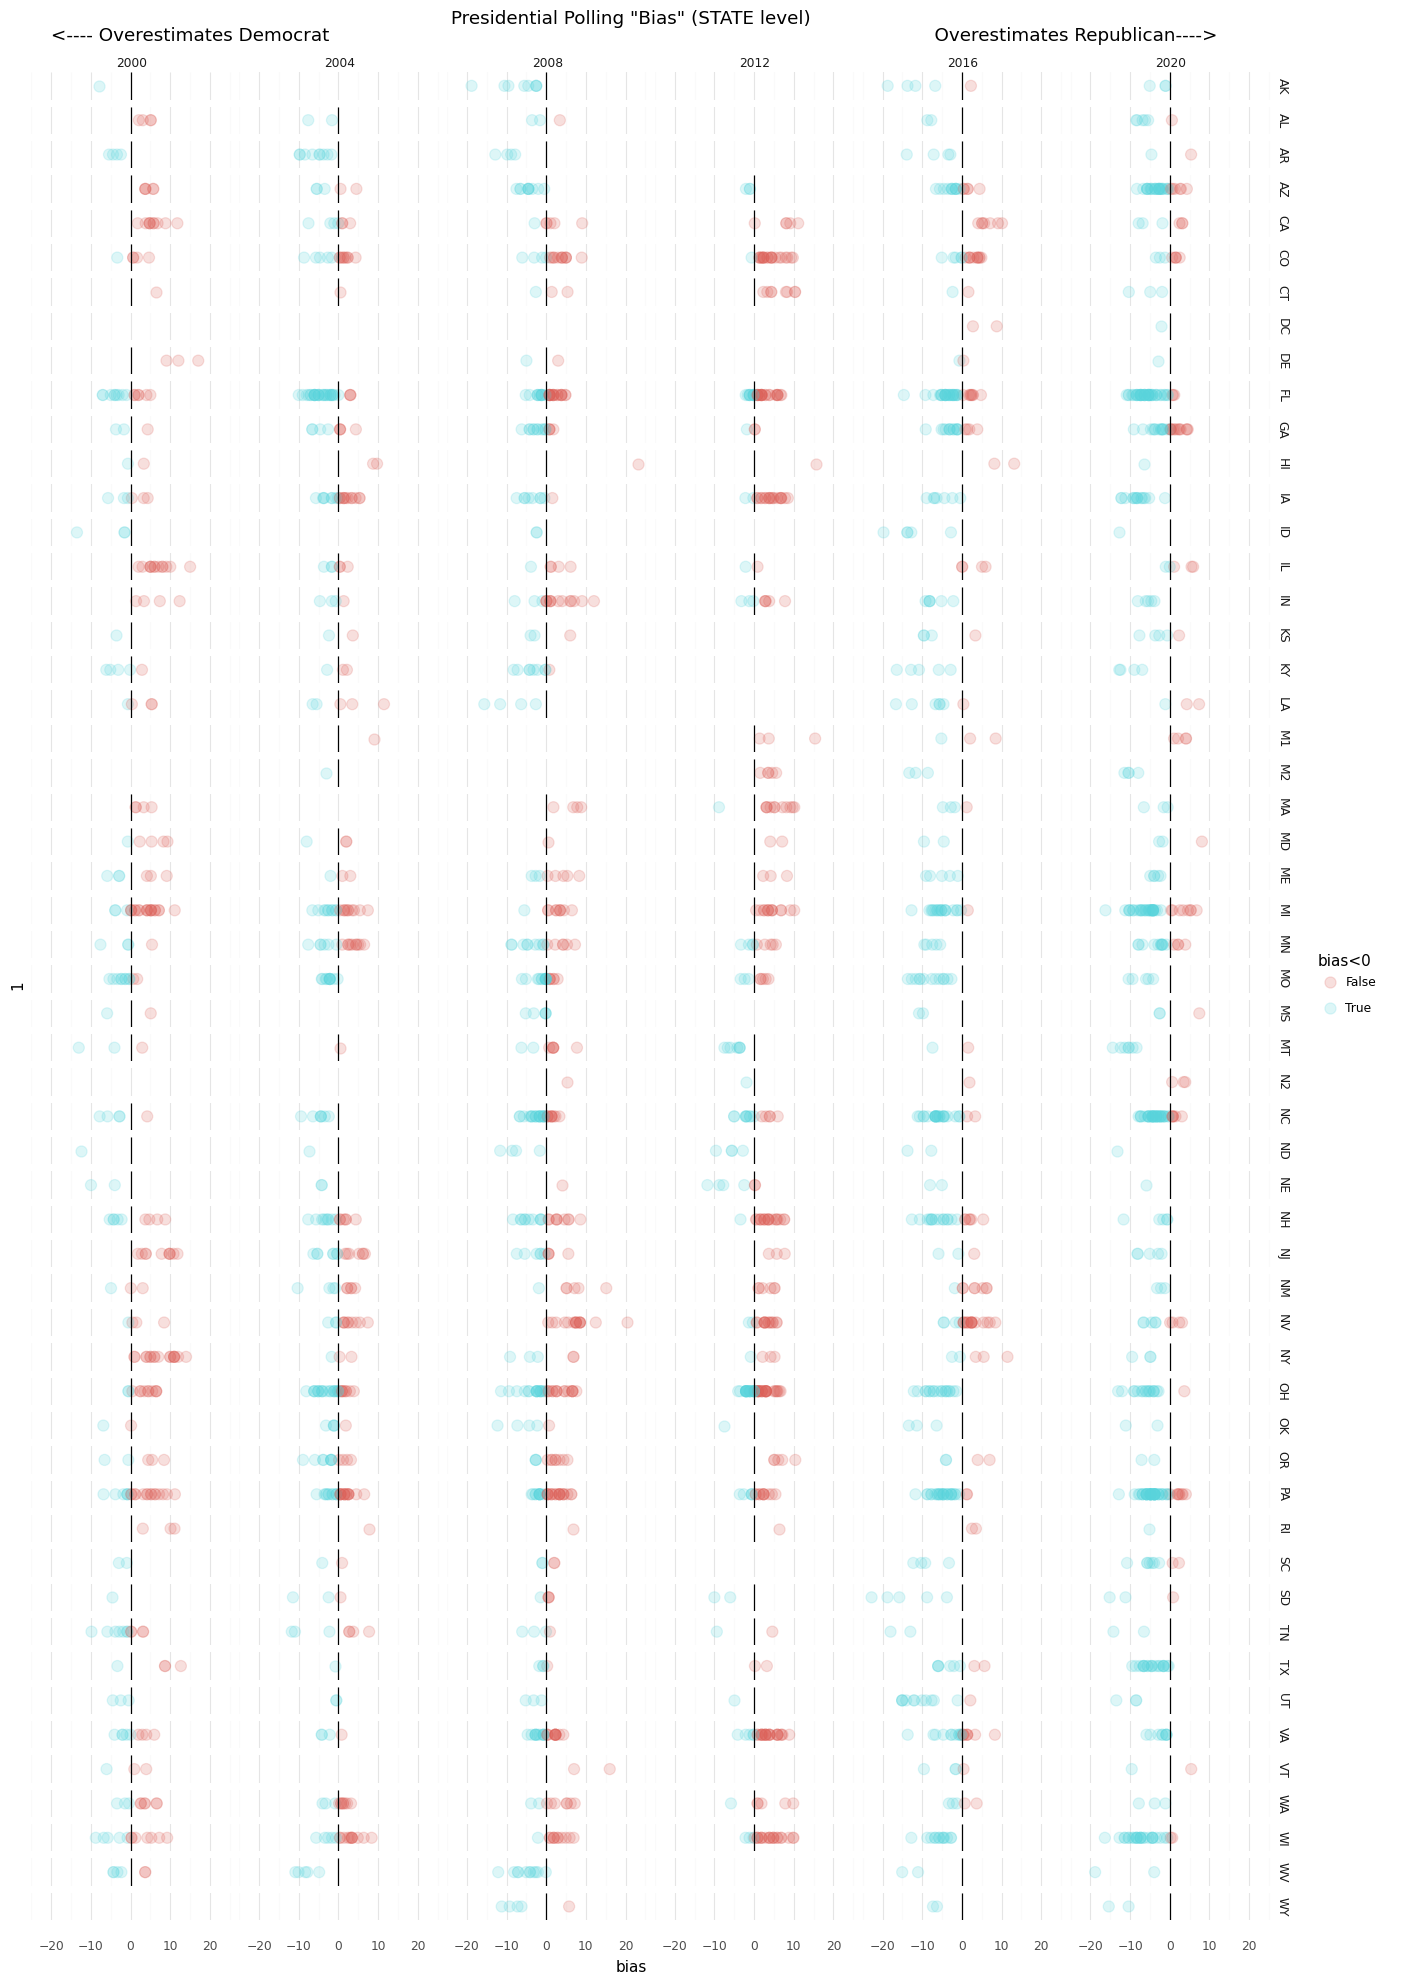

<ggplot: (339217038)>

In [118]:
(
    ggplot(presidential_state_level_polls
           , aes(x='bias', y=1, color='bias<0'))
     + geom_point(size=4, alpha=.2)
     + geom_vline(aes(xintercept=0))
     + theme_minimal()
     + scale_y_continuous(breaks=list(range(2000,2024,4)))
     + facet_grid('location~year')
     + theme(figure_size=(16, 24)) 
         + labs(title='Presidential Polling "Bias" (STATE level)\n <---- Overestimates Democrat                                                                                                       Overestimates Republican---->')

)

### What have we noticed about the presidential polls at the state level compared to the national level?

<details><summary> ---> DON'T CLICK ME </summary>
<p>

* State level polls seem less accurate than national polls
* Some states have a lot more polling than others
* Polling in Hawaii is historically super inaccurate
* State level polling errors are correlated in any given year
```

</p>
</details>


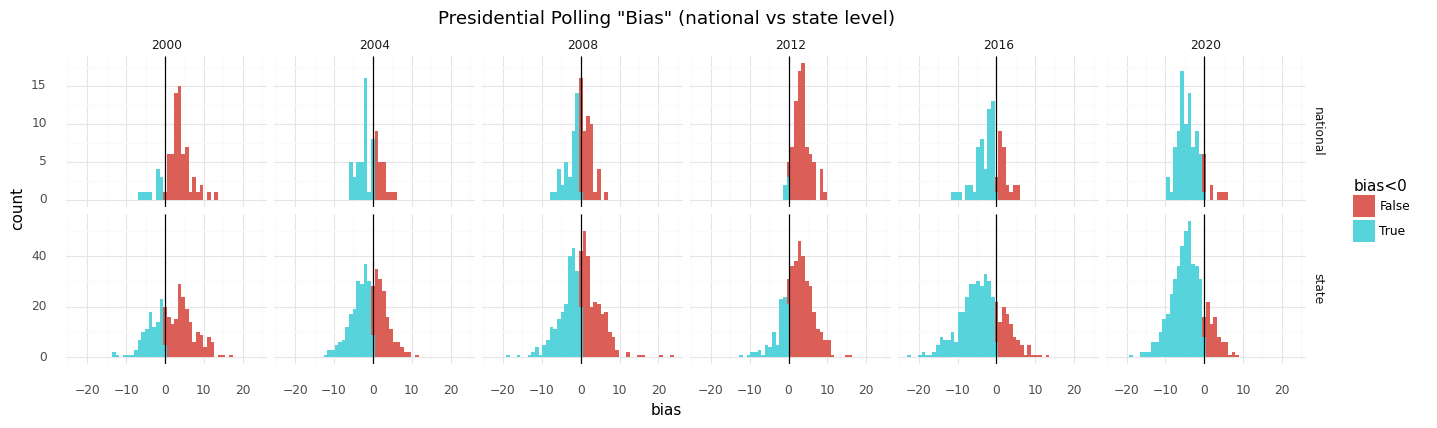

<ggplot: (338388128)>

In [149]:
# state-level presidential polls over the years
polls_to_analyze = polls.query("type_detail=='Pres-G'")

(
    ggplot(polls_to_analyze, aes(x='bias', fill='bias<0'))
     + geom_histogram()
     + geom_vline(aes(xintercept=0))
     + theme_minimal()
     + facet_grid('national~year', scales='free_y')
     + theme(figure_size=(16, 4)) 
     + labs(title='Presidential Polling "Bias" (national vs state level)')

)

## What about polling in primary elections?

In [18]:
# Primary and general elections
polls_to_analyze = polls.query("type_detail.isin(['Pres-G', 'Pres-R', 'Pres-D']) and error.notna()")
polls_to_analyze = polls_to_analyze.query("national=='state'")

# # polls_to_analyze = polls_to_analyze.query("location.isin(@swing_states_2020)")
# display(
#     ggplot(polls_to_analyze, aes(x='error'))
#      + geom_histogram()
#      + theme_minimal()
#      + facet_grid('type_detail~year', scales='free_y')
#      + theme(figure_size=(16, 4)) 
#      + labs(title='Presidential Polling "Bias" (STATE level)')

# )

display(
    polls_to_analyze.pivot_table(index='type_detail', values='error', columns='year',aggfunc='mean').T.round(1).fillna('')
)

type_detail Pres-D  Pres-G Pres-R
year                             
2000           6.5     4.6    8.8
2004           7.1     3.3       
2008           7.7     3.6    7.0
2012                   3.7    8.6
2016          10.5     5.4    8.3
2020          10.3     5.0    7.2

## And how about Senate, House, Governor, etc...?

In [13]:
(
    polls
    .pivot_table(index=['type_simple'], values='error', columns='national',aggfunc='mean')
    .round(1)
    .fillna('')
)


national    national  state
type_simple                
Gov-G                   5.1
House-G          4.0    6.3
Pres-G           3.1    4.3
Pres-P                  8.4
Sen-G                   5.2

# Are polls becoming less accurate over time? 

In [14]:
(
    polls.query('year%2==0')
    .pivot_table(index=['type_simple', 'national'], values='error', columns='year',aggfunc='mean')
    .round(1)
    .fillna('')
    .T
)


type_simple Gov-G  House-G         Pres-G       Pres-P Sen-G
national    state national state national state  state state
year                                                        
1998          8.1      4.6   8.3                         6.8
2000          3.7      3.4   5.6      3.7   4.6    7.9   5.4
2002          5.4      5.0   5.7                         4.9
2004          3.2      4.7   5.6      2.2   3.3    7.1   5.0
2006          4.7      6.9   5.9                         5.2
2008          4.7      2.8   6.4      2.2   3.6    7.4   4.9
2010          4.7      3.2   7.2                         5.4
2012          4.7      1.8   6.1      3.5   3.7    8.6   4.7
2014          4.8      4.5   7.0                         5.3
2016          6.2      2.7   6.9      2.9   5.4    9.4   5.4
2018          4.7      3.7   5.1                         4.1
2020          7.0      4.7   7.3      4.2   5.0   10.2   5.6

# Part 2: Statistical Treatment

Statistical treatment can help you get more out of a dataset! Sometimes the polls miss, but have consistent biases one way or another. If we can detect these patterns, we can correct for them and get more out of the data. Here is one example of how. Let's take a look at what we know about each pollster

- Pollster Ratings: https://projects.fivethirtyeight.com/pollster-ratings/
- Methodology: https://fivethirtyeight.com/features/how-fivethirtyeight-calculates-pollster-ratings/
- Latest Update: https://fivethirtyeight.com/features/the-state-of-the-polls-2019/

In [15]:
pollster_ratings = pd.read_csv('pollster-ratings.csv').set_index('Pollster Rating ID')
pollster_ratings.head()

Rank                                 Pollster  \
Pollster Rating ID                                                  
304                    1                             Selzer & Co.   
3                      2             ABC News/The Washington Post   
448                    3  Siena College/The New York Times Upshot   
144                    4                                 IBD/TIPP   
94                     5        Field Research Corp. (Field Poll)   

                    Polls Analyzed NCPP/AAPOR/Roper Banned by 538  \
Pollster Rating ID                                                  
304                             50              yes            no   
3                               82              yes            no   
448                             83              yes            no   
144                             31              yes            no   
94                              25              yes            no   

                    Predictive Plus-Minus 538 Grade  Mean-Reverted Bias  \
Pollster Rating ID                                                        
304                             -1.164872        A+            0.106846   
3                               -0.991960        A+            0.919807   
448                             -0.954452        A+            1.142941   
144                             -0.938424        A+           -0.832351   
94                              -0.906695       A/B           -0.682868   

                    Races Called Correctly  Misses Outside MOE  \
Pollster Rating ID                                               
304                               0.780000            0.240000   
3                                 0.737805            0.085366   
448                               0.728916            0.204819   
144                               0.806452            0.032258   
94                                1.000000            0.200000   

                    Simple Average Error  Simple Expected Error  \
Pollster Rating ID                                                
304                             4.562133               5.959977   
3                               3.053507               4.972745   
448                             4.352682               5.364920   
144                             2.085002               4.009343   
94                              4.103997               5.990497   

                    Simple Plus-Minus  Advanced Plus-Minus  \
Pollster Rating ID                                           
304                         -1.392989            -1.623991   
3                           -1.914383            -1.328717   
448                         -1.007384            -1.309741   
144                         -1.919487            -1.512109   
94                          -1.881646            -2.473643   

                    Mean-Reverted Advanced Plus Minus  \
Pollster Rating ID                                      
304                                         -1.006764   
3                                           -0.980676   
448                                         -1.055391   
144                                         -0.792614   
94                                          -0.923134   

                    # of Polls for Bias Analysis      Bias  House Effect  \
Pollster Rating ID                                                         
304                                           33  0.201305     -0.243631   
3                                             77  1.256719      1.231279   
448                                           82  1.422586      0.231204   
144                                           31 -1.587916     -1.814818   
94                                            18 -2.455076      0.725441   

                    Average Distance from Polling Average (ADPA)  \
Pollster Rating ID                                                 
304                                                     5.339089   
3                    

> **Mean-Reverted Bias** - A pollster's historical average statistical bias toward Democratic or Republican candidates, reverted to a mean of zero based on the number of polls in the database. A score of "R +1.5", for example, indicates that the pollster has historically overrated the performance of the Republican candidate.

> **House Effect** The average amount by which the firm's polls have shown more favorable results for Democratic or Republican candidates as compared to other surveys of the same race. For instance, if a poll showed the Republican ahead by 5 percentage points, and the average of other polls in the same race showed the Republican ahead by 2 percentage points, it would have a House Effect score of R+3. This is not the same thing as the Bias calculation -- House Effect compares a poll to other surveys of the same races rather than against actual results. Cases in which the firm was the only one to survey the race are not included in the calculation.

> **Average Distance from Polling Average (ADPA)** How far the firm's average poll differed from the average of other polls in the field at the time it was released. Specifically, the average is calculated based on the most recent poll (among polls in the pollster rating database) from each other firm that polled the race, provided that the poll was not partisan and that the pollster is not banned by FiveThirtyEight. A low ADPA is potential evidence of herding.

> **Herding Penalty** A herding penalty is triggered when a firm's ADPA is lower than the theoretical minimum based on the sampling error in it's polls. For instance, if a pollster's ADPA is 3.5, but you'd expect its polls to deviate by a minimum of 4.5 points from the polling average given sampling error based on its sample sizes, the firm would receive a herding penalty of 1 point. This penalty is added to a firm's Advanced Plus-Minus score before calculating Predictive Plus-Minus.


In [22]:
# Append grade
polls['grade'] = polls.pollster_rating_id.apply(lambda x: pollster_ratings.loc[x]['538 Grade'] if x in pollster_ratings.index else None)

# Append MRB and chnage it to an integer value
polls['mrb'] = polls.pollster_rating_id.apply(lambda x: -pollster_ratings.loc[x]['Mean-Reverted Bias'] if x in pollster_ratings.index else None)
# reverse polarity to match above charts where D is left (-) and R is right (+)
# polls['mrb'] = -pd.to_numeric(polls['mrb'].str.replace('D +', '', regex=False).str.replace('R +', '-', regex=False))

# Adjust poll, bias, and error by MRB
polls['margin_poll_adjusted'] = polls['margin_poll'] - polls['mrb']
polls['bias_adjusted'] = polls.margin_poll_adjusted - polls.margin_actual
polls['error_adjusted'] = np.abs(polls.margin_poll_adjusted - polls.margin_actual)


In [27]:
# Select all state and national polls
pres_polls_national = polls.query("type_detail=='Pres-G' and location=='US'")
pres_polls_by_state = polls.query("type_detail=='Pres-G' and location!='US'")


Beware of "Unskewing" polls

In [31]:
pres_polls_by_state.query("year==2016 and location=='GA'")\
    [['pollster', 'grade', 'margin_actual', 'margin_poll', 'margin_poll_adjusted', 'mrb', 'error', 'error_adjusted']]\
    .assign(better=lambda df: df.error_adjusted < df.error)

pollster grade  margin_actual  margin_poll  \
8011                           Lucid    B-           5.13        -4.00   
8045                  Abt Associates   A/B           5.13         2.00   
8065         Landmark Communications     A           5.13         4.00   
8066  Opinion Savvy/InsiderAdvantage     B           5.13         4.00   
8165           Quinnipiac University    A-           5.13         0.50   
8259                       SurveyUSA     A           5.13         7.00   
8380                    SurveyMonkey     C           5.13         2.00   
8497                 Emerson College    A-           5.13         9.00   
8546                  Marist College     A           5.13         1.00   
8683         Landmark Communications     A           5.13         2.00   
8684  Opinion Savvy/InsiderAdvantage     B           5.13         3.80   
8777                   20/20 Insight   B/C           5.13         3.00   
8778                    SurveyMonkey     C           5.13        -0.00   
8779                          YouGov    B+           5.13         6.00   
8866                Gravis Marketing     B           5.13         4.00   
8895         Landmark Communications     A           5.13         3.00   
8896                 Trafalgar Group    A-           5.13         6.47   

      margin_poll_adjusted       mrb  error  error_adjusted  better  
8011             -2.076856 -1.923144   9.13        7.206856    True  
8045              2.813337 -0.813337   3.13        2.316663    True  
8065              5.414304 -1.414304   1.13        0.284304    True  
8066              5.134172 -1.134172   1.13        0.004172    True  
8165              1.048557 -0.548557   4.63        4.081443    True  
8259              7.048469 -0.048469   1.87        1.918469   False  
8380              6.742323 -4.742323   3.13        1.612323    True  
8497              9.843247 -0.843247   3.87        4.713247   False  
8546              1.106988 -0.106988   4.13        4.023012    True  
8683              3.414304 -1.414304   3.13        1.715696    True  
8684              4.934172 -1.134172   1.33        0.195828    True  
8777              3.519450 -0.519450   2.13        1.610550    True  
8778              4.742323 -4.742323   5.13        0.387677    True  
8779              6.676634 -0.676634   0.87        1.546634   False  
8866              5.453605 -1.453605   1.13        0.323605    True  
8895              4.414304 -1.414304   2.13        0.715696    True  
8896              5.147119  1.322881   1.34        0.017119    True

In [30]:
pres_polls_by_state.query("year==2016 and location=='HI'")\
    [['pollster', 'grade', 'margin_actual', 'margin_poll', 'margin_poll_adjusted', 'mrb', 'error', 'error_adjusted']]\
    .assign(better=lambda df: df.error_adjusted < df.error)

pollster grade  margin_actual  margin_poll  margin_poll_adjusted  \
8381  SurveyMonkey     C         -32.18        -19.0            -14.257677   
8780  SurveyMonkey     C         -32.18        -24.0            -19.257677   

           mrb  error  error_adjusted  better  
8381 -4.742323  13.18       17.922323   False  
8780 -4.742323   8.18       12.922323   False

Uh oh, what happened here? 

Statistical treatments don't necessarily improve each individual poll result. But on average, when incoporated into your analysis they will help you get more information from the aggregate of your data.

Still, in the aggregate:
* you're better off looking at the average of the polls rather than one poll.
* you're better off looking at the adjusted average than a raw average *IF* the adjustment is done well
* this is only one statsitical treatment! Remember how Hawaii polls tend to underestimate how well Democrats will do? We have adjusted for the pollster's average bias, but have not accounted for factors like that. And there are so many other things to consider! When you start adjusting for lots of factors and also incorporating other factors known to be predictive of elections, you get an election forecast.

# Election Forecast Models

Let's talk about our election forecasts, which apply a lot of statistical treatments based on what we know about the nature of politics and political data in the U.S.


## Forecasts

### 2020 Forecast

- Forecast: https://projects.fivethirtyeight.com/2020-election-forecast/
- Methodology: https://fivethirtyeight.com/features/how-fivethirtyeights-2020-presidential-forecast-works-and-whats-different-because-of-covid-19/


### 2016 Forecast

- Forecast: https://projects.fivethirtyeight.com/2016-election-forecast/
- Methodology: https://fivethirtyeight.com/features/a-users-guide-to-fivethirtyeights-2016-general-election-forecast/
- Analysis: https://projects.fivethirtyeight.com/2016-election-forecast/articles/?ex_cid=2016-forecast

### 2018 Forecast

- https://projects.fivethirtyeight.com/2018-midterm-election-forecast/senate
- https://projects.fivethirtyeight.com/2018-midterm-election-forecast/house


## Polls Stories from 2016

These help elucidate how we turn analysis, like what you just did above, into insights for our readers.

- https://fivethirtyeight.com/features/how-much-the-polls-missed-by-in-every-state/
- https://fivethirtyeight.com/features/pollsters-probably-didnt-talk-to-enough-white-voters-without-college-degrees/
- https://fivethirtyeight.com/features/what-a-difference-2-percentage-points-makes/
- https://fivethirtyeight.com/features/shy-voters-probably-arent-why-the-polls-missed-trump/
- https://fivethirtyeight.com/features/the-polls-missed-trump-we-asked-pollsters-why/
- https://fivethirtyeight.com/features/why-fivethirtyeight-gave-trump-a-better-chance-than-almost-anyone-else/
- https://fivethirtyeight.com/features/the-polls-are-all-right/
- https://fivethirtyeight.com/features/trump-is-just-a-normal-polling-error-behind-clinton/



## Some other folks

- [CNN](https://www.cnn.com/election/2018/forecast)
- [Daily Kos](https://elections.dailykos.com/)
- [New York Times - Real Time Polling!](https://www.nytimes.com/interactive/2018/upshot/elections-polls.html)


# Visualizing Uncertainty

- FiveThirtyEight in [2010](https://www.nytimes.com/elections/2010/forecasts/senate.html), [2014](https://fivethirtyeight.com/interactives/senate-forecast/), [2016](https://projects.fivethirtyeight.com/2016-election-forecast/), [2018](https://projects.fivethirtyeight.com/2018-midterm-election-forecast/house/)
    * I think 2010 still works in Safari...
- New York Times
    * The Spinners https://www.nytimes.com/2014/11/01/upshot/how-confirmation-bias-can-lead-to-a-spinning-of-wheels.html
    * The Needle https://www.youtube.com/watch?v=iq5rW6zYeP4
- [Huffpost's](http://elections.huffingtonpost.com/pollster) custom charts.

